## Imports

In [1]:
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow
import scipy.signal as sl
from typing import Optional
import scipy as sp
from mneflow.layers import LFTConv, DeMixing, Dense
from tensorflow.keras.layers import Dropout
from alltools.machine_learning.convtools import conviter

In [2]:
def interpolate_sequence(original_sequence: np.ndarray, new_length: int) -> np.ndarray:
    """
    Interpolate a sequence of length 'n' into a sequence of length 'm' (m > n)

    Args:
        original_sequence: A numpy array of shape (n, ) representing the original sequence
        new_length: An integer, the desired length of the interpolated sequence

    Returns:
        A numpy array of shape (m, ) representing the interpolated sequence
    """
    x = np.arange(original_sequence.shape[0])
    f = original_sequence
    x_new = np.linspace(0, x.max(), new_length)
    f_new = np.interp(x_new, x, f)
    return f_new

## Original SimpleNet class

In [3]:
class SimpleNet(mneflow.models.LFCNN):
    def __init__(self, Dataset, specs=None):
        if specs is None:
            specs=dict()
        super().__init__(Dataset, specs)

    def build_graph(self):
        self.dmx = DeMixing(size=self.specs['n_latent'], nonlin=tf.identity,
                            axis=3, specs=self.specs)
        self.dmx_out = self.dmx(self.inputs)

        self.tconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=tf.identity,
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )
        self.tconv_out = self.tconv(self.dmx_out)
        # self.tconv_out = tf.math.abs(self.tconv(self.dmx_out))

        # self.envconv = LFTConv(
        #     size=self.specs['n_latent'],
        #     nonlin=tf.identity,
        #     filter_length=self.specs['filter_length'],
        #     padding=self.specs['padding'],
        #     specs=self.specs
        # )

        # self.envconv_out = self.envconv(self.tconv_out)
        self.envconv_out = self.tconv_out
        self.pool = lambda X: X[:, :, ::self.specs['pooling'], :]

        self.pooled = self.pool(self.envconv_out)

        dropout = Dropout(
            self.specs['dropout'],
            noise_shape=None
        )(self.pooled)

        self.fin_fc = Dense(size=self.out_dim, nonlin=tf.identity,
                            specs=self.specs)

        y_pred = self.fin_fc(dropout)

        return y_pred

    def compute_patterns(self, data_path=None, *, output='patterns'):

        if not data_path:
            print("Computing patterns: No path specified, using validation dataset (Default)")
            ds = self.dataset.val
        elif isinstance(data_path, str) or isinstance(data_path, (list, tuple)):
            ds = self.dataset._build_dataset(
                data_path,
                split=False,
                test_batch=None,
                repeat=True
            )
        elif isinstance(data_path, mneflow.data.Dataset):
            if hasattr(data_path, 'test'):
                ds = data_path.test
            else:
                ds = data_path.val
        elif isinstance(data_path, tf.data.Dataset):
            ds = data_path
        else:
            raise AttributeError('Specify dataset or data path.')

        X, y = [row for row in ds.take(1)][0]

        self.out_w_flat = self.fin_fc.w.numpy()
        self.out_weights = np.reshape(
            self.out_w_flat,
            [-1, self.dmx.size, self.out_dim]
        )
        self.out_biases = self.fin_fc.b.numpy()
        self.feature_relevances = self.componentwise_loss(X, y)
        self.branchwise_loss(X, y)

        # compute temporal convolution layer outputs for vis_dics
        tc_out = self.pool(self.tconv(self.dmx(X)).numpy())

        # compute data covariance
        X = X - tf.reduce_mean(X, axis=-2, keepdims=True)
        X = tf.transpose(X, [3, 0, 1, 2])
        X = tf.reshape(X, [X.shape[0], -1])
        self.dcov = tf.matmul(X, tf.transpose(X))

        # get spatial extraction fiter weights
        demx = self.dmx.w.numpy()

        kern = np.squeeze(self.tconv.filters.numpy()).T

        X = X.numpy().T
        if 'patterns' in output:
            if 'old' in output:
                self.patterns = np.dot(self.dcov, demx)
            else:
                patterns = []
                X_filt = np.zeros_like(X)
                for i_comp in range(kern.shape[0]):
                    for i_ch in range(X.shape[1]):
                        x = X[:, i_ch]
                        X_filt[:, i_ch] = np.convolve(x, kern[i_comp, :], mode="same")
                    patterns.append(np.cov(X_filt.T) @ demx[:, i_comp])
                self.patterns = np.array(patterns).T
                self.lat_tcs_filt = np.dot(demx.T, X_filt.T)
        else:
            self.patterns = demx

        self.lat_tcs = np.dot(demx.T, X.T)

        del X

        #  Temporal conv stuff
        self.filters = kern.T
        self.tc_out = np.squeeze(tc_out)
        self.corr_to_output = self.get_output_correlations(y)

    def plot_patterns(
        self, sensor_layout=None, sorting='l2', percentile=90,
        scale=False, class_names=None, info=None
    ):
        order, ts = self._sorting(sorting)
        self.uorder = order.ravel()
        l_u = len(self.uorder)
        if info:
            info.__setstate__(dict(_unlocked=True))
            info['sfreq'] = 1.
            self.fake_evoked = evoked.EvokedArray(self.patterns, info, tmin=0)
            if l_u > 1:
                self.fake_evoked.data[:, :l_u] = self.fake_evoked.data[:, self.uorder]
            elif l_u == 1:
                self.fake_evoked.data[:, l_u] = self.fake_evoked.data[:, self.uorder[0]]
            self.fake_evoked.crop(tmax=float(l_u))
            if scale:
                _std = self.fake_evoked.data[:, :l_u].std(0)
                self.fake_evoked.data[:, :l_u] /= _std
        elif sensor_layout:
            lo = channels.read_layout(sensor_layout)
            info = create_info(lo.names, 1., sensor_layout.split('-')[-1])
            orig_xy = np.mean(lo.pos[:, :2], 0)
            for i, ch in enumerate(lo.names):
                if info['chs'][i]['ch_name'] == ch:
                    info['chs'][i]['loc'][:2] = (lo.pos[i, :2] - orig_xy)/3.
                    #info['chs'][i]['loc'][4:] = 0
                else:
                    print("Channel name mismatch. info: {} vs lo: {}".format(
                        info['chs'][i]['ch_name'], ch))

            self.fake_evoked = evoked.EvokedArray(self.patterns, info)

            if l_u > 1:
                self.fake_evoked.data[:, :l_u] = self.fake_evoked.data[:, self.uorder]
            elif l_u == 1:
                self.fake_evoked.data[:, l_u] = self.fake_evoked.data[:, self.uorder[0]]
            self.fake_evoked.crop(tmax=float(l_u))
            if scale:
                _std = self.fake_evoked.data[:, :l_u].std(0)
                self.fake_evoked.data[:, :l_u] /= _std
        else:
            raise ValueError("Specify sensor layout")


        if np.any(self.uorder):
            nfilt = max(self.out_dim, 8)
            nrows = max(1, l_u//nfilt)
            ncols = min(nfilt, l_u)
            f, ax = plt.subplots(nrows, ncols, sharey=True)
            plt.tight_layout()
            f.set_size_inches([16, 3])
            ax = np.atleast_2d(ax)

            for ii in range(nrows):
                fake_times = np.arange(ii * ncols,  (ii + 1) * ncols, 1.)
                vmax = np.percentile(self.fake_evoked.data[:, :l_u], 95)
                self.fake_evoked.plot_topomap(
                    times=fake_times,
                    axes=ax[ii],
                    colorbar=False,
                    vmax=vmax,
                    scalings=1,
                    time_format="Branch #%g",
                    title='Patterns ('+str(sorting)+')',
                    outlines='head',
                )

    # def branchwise_loss(self, X, y):
    #     model_weights_original = self.km.get_weights().copy()
    #     base_loss, _ = self.km.evaluate(X, y, verbose=0)

    #     losses = []
    #     for i in range(self.specs["n_latent"]):
    #         model_weights = model_weights_original.copy()
    #         spatial_weights = model_weights[0].copy()
    #         spatial_biases = model_weights[1].copy()
    #         temporal_biases = model_weights[3].copy()
    #         env_biases = model_weights[5].copy()
    #         spatial_weights[:, i] = 0
    #         spatial_biases[i] = 0
    #         temporal_biases[i] = 0
    #         env_biases[i] = 0
    #         model_weights[0] = spatial_weights
    #         model_weights[1] = spatial_biases
    #         model_weights[3] = temporal_biases
    #         model_weights[5] = env_biases
    #         self.km.set_weights(model_weights)
    #         losses.append(self.km.evaluate(X, y, verbose=0)[0])
    #     self.km.set_weights(model_weights_original)
    #     self.branch_relevance_loss = base_loss - np.array(losses)

    def branchwise_loss(self, X, y):
        self_weights_original = self.km.get_weights().copy()
        base_loss, _ = self.km.evaluate(X, y, verbose=0)

        losses = []
        for i in range(self.specs["n_latent"]):
            self_weights = self_weights_original.copy()
            spatial_weights = self_weights[0].copy()
            # spatial_biases = self_weights[1].copy()
            # temporal_biases = self_weights[3].copy()
            spatial_weights[:, i] = 0
            # spatial_biases[i] = 0
            # temporal_biases[i] = 0
            self_weights[0] = spatial_weights
            # self_weights[1] = spatial_biases
            # self_weights[3] = temporal_biases
            self.km.set_weights(self_weights)
            losses.append(self.km.evaluate(X, y, verbose=0)[0])
        self.km.set_weights(self_weights_original)
        self.branch_relevance_loss = base_loss - np.array(losses)

    def plot_branch(
        self,
        branch_num: int,
        info: mne.Info,
        params: Optional[list[str]] = ['input', 'output', 'response']
    ):
        info.__setstate__(dict(_unlocked=True))
        info['sfreq'] = 1.
        sorting = np.argsort(self.branch_relevance_loss)[::-1]
        data = self.patterns[:, sorting]
        filters = self.filters[:, sorting]
        relevances = self.branch_relevance_loss - self.branch_relevance_loss.min()
        relevance = sorted([np.round(rel/relevances.sum(), 2) for rel in relevances], reverse=True)[branch_num]
        self.fake_evoked = evoked.EvokedArray(data, info, tmin=0)
        fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
        fig.tight_layout()

        self.fs = self.dataset.h_params['fs']

        out_filter = filters[:, branch_num]
        _, psd = sl.welch(self.lat_tcs[branch_num], fs=self.fs, nperseg=self.fs * 2)
        w, h = (lambda w, h: (w, h))(*sl.freqz(out_filter, 1, worN=self.fs))
        frange = w / np.pi * self.fs / 2
        z = lambda x: (x - x.mean())/x.std()

        for param in params:
            if param == 'input':
                finput = psd[:-1]
                finput = z(finput)
                ax2.plot(frange, finput - finput.min(), color='tab:blue')
            elif param == 'output':
                foutput = np.real(finput * h * np.conj(h))
                foutput = z(foutput)
                ax2.plot(frange, foutput - foutput.min(), color='tab:orange')
            elif param == 'response':
                fresponce = np.abs(h)
                fresponce = z(fresponce)
                ax2.plot(frange, fresponce - fresponce.min(), color='tab:green')
            elif param == 'pattern':
                fpattern = finput * np.abs(h)
                fpattern = z(fpattern)
                ax2.plot(frange, fpattern - fpattern.min(), color='tab:pink')

        ax2.legend([param.capitalize() for param in params])
        ax2.set_xlim(0, 100)

        fig.suptitle(f'Branch {branch_num}', y=0.95, x=0.2, fontsize=30)
        fig.set_size_inches(10, 5)
        self.fake_evoked.plot_topomap(
            times=branch_num,
            axes=ax1,
            colorbar=False,
            scalings=1,
            time_format="",
            outlines='head',
        )

        return fig


## SimpleNet with weighted compression of envelopes

In [4]:
def eigencentrality(matrix):
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    eigencentrality = eigenvectors[:,0]
    return eigencentrality

gaussian = lambda x, mu, sigma: 1/(np.sqrt(2*np.pi*sigma**2))*np.exp((-(x - mu)**2)/(2*sigma**2))

In [5]:
class SimpleNetA(SimpleNet):
    def __init__(self, Dataset, specs=None):
        if specs is None:
            specs=dict()
        super().__init__(Dataset, specs)

    def build_graph(self):
        self.dmx = DeMixing(size=self.specs['n_latent'], nonlin=tf.identity,
                            axis=3, specs=self.specs)
        self.dmx_out = self.dmx(self.inputs)

        self.tconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=tf.identity,
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )
        self.tconv_out = self.tconv(self.dmx_out)
        self.envconv_out = self.tconv_out
        # self.envconv_out = self.tconv_out
        # print(self.envconv_out.shape)
        n_times = self.envconv_out.shape[-2]
        pooled_dim = n_times // self.specs['pooling']
        # self.pool = lambda X: X[:, :, ::self.specs['pooling'], :]
        self.pool_list = [
            tf.keras.layers.Dense(
                pooled_dim,
                use_bias=False,
                # kernel_regularizer='l2',
                activation='sigmoid'
                # activation='tanh'
                # activation='linear'
                # activation='relu'
            )
            for _ in range(self.specs['n_latent'])
        ]
        # self.pool = DepthwiseSelectTimepointsLayer(10)
        pooled = list()
        for i, pooling in enumerate(self.pool_list):
            pooled.append(pooling(self.envconv_out[:, :, :, i]))

        self.pooled = tf.stack(pooled, -1)
        # self.pooled = self.pool(self.envconv_out)

        dropout = Dropout(
            self.specs['dropout'],
            noise_shape=None
        )(self.pooled)

        self.fin_fc = Dense(size=self.out_dim, nonlin=tf.identity,
                            specs=self.specs)

        y_pred = self.fin_fc(dropout)

        return y_pred

    # def plot_temporal
    def branchwise_loss(self, X, y):
        self_weights_original = self.km.get_weights().copy()
        base_loss, _ = self.km.evaluate(X, y, verbose=0)

        losses = []
        for i in range(self.specs["n_latent"]):
            self_weights = self_weights_original.copy()
            spatial_weights = self_weights[0].copy()
            # spatial_biases = self_weights[1].copy()
            # temporal_biases = self_weights[3].copy()
            spatial_weights[:, i] = 0
            # spatial_biases[i] = 0
            # temporal_biases[i] = 0
            self_weights[0] = spatial_weights
            # self_weights[1] = spatial_biases
            # self_weights[3] = temporal_biases
            self.km.set_weights(self_weights)
            losses.append(self.km.evaluate(X, y, verbose=0)[0])
        self.km.set_weights(self_weights_original)
        self.branch_relevance_loss = base_loss - np.array(losses)

    def tempwise_loss(self, X, y):
        self_weights_original = self.km.get_weights().copy()
        temp_sel_weights = self_weights_original[2:-2]
        base_loss, _ = self.km.evaluate(X, y, verbose=0)
        window_size = 1
        componentslosses = list()
        for i_latent, tem_sel_w in enumerate(temp_sel_weights):
            print(f'Processing branch {i_latent}...', end='')
            timelosses = list()
            for i_timepoint in range(0, len(tem_sel_w), window_size):
                tem_sel_w_copy = tem_sel_w.copy()
                tem_sel_w_copy[:i_timepoint, :] = 0
                tem_sel_w_copy[i_timepoint+min(window_size, len(tem_sel_w) - i_timepoint):, :] = 0
                temp_sel_weights_copy = temp_sel_weights.copy()
                temp_sel_weights_copy[i_latent] = tem_sel_w_copy
                for i in range(len(temp_sel_weights_copy)):
                    if i != i_latent:
                        temp_sel_weights_copy[i] = np.zeros_like(temp_sel_weights_copy[i])
                self_weights = self_weights_original.copy()
                # sp w = 1, sp b = 2, tp w = 3, tp b = 4, env w = 5, env b = 6
                # self_weights[6:-2] = temp_sel_weights_copy
                self_weights[2:-2] = temp_sel_weights_copy
                self.km.set_weights(self_weights)
                loss = self.km.evaluate(X, y, verbose=0)[0]
                timelosses += [loss for _ in range(min(window_size, len(tem_sel_w) - i_timepoint))]
            componentslosses.append(timelosses)
            print(f'\tDONE, {len(timelosses)}')
        self.km.set_weights(self_weights_original)
        self.temp_relevance_loss = - np.array(componentslosses)

    def compute_patterns(self, data_path=None, *, output='patterns'):
        if not data_path:
            print("Computing patterns: No path specified, using validation dataset (Default)")
            ds = self.dataset.val
        elif isinstance(data_path, str) or isinstance(data_path, (list, tuple)):
            ds = self.dataset._build_dataset(
                data_path,
                split=False,
                test_batch=None,
                repeat=True
            )
        elif isinstance(data_path, mneflow.data.Dataset):
            if hasattr(data_path, 'test'):
                ds = data_path.test
            else:
                ds = data_path.val
        elif isinstance(data_path, tf.data.Dataset):
            ds = data_path
        else:
            raise AttributeError('Specify dataset or data path.')

        X, y = [row for row in ds.take(1)][0]

        self.out_w_flat = self.fin_fc.w.numpy()
        self.out_weights = np.reshape(
            self.out_w_flat,
            [-1, self.dmx.size, self.out_dim]
        )
        self.out_biases = self.fin_fc.b.numpy()
        self.feature_relevances = self.componentwise_loss(X, y)
        self.branchwise_loss(X, y)
        self.tempwise_loss(X, y)

        # compute temporal convolution layer outputs for vis_dics
        tc_out = self.tconv(self.dmx(X)).numpy()

        # compute data covariance
        X = X - tf.reduce_mean(X, axis=-2, keepdims=True)
        X = tf.transpose(X, [3, 0, 1, 2])
        X = tf.reshape(X, [X.shape[0], -1])
        self.dcov = tf.matmul(X, tf.transpose(X))

        # get spatial extraction fiter weights
        demx = self.dmx.w.numpy()

        kern = np.squeeze(self.tconv.filters.numpy()).T

        X = X.numpy().T
        if 'patterns' in output:
            if 'old' in output:
                self.patterns = np.dot(self.dcov, demx)
            else:
                patterns = []
                X_filt = np.zeros_like(X)
                for i_comp in range(kern.shape[0]):
                    for i_ch in range(X.shape[1]):
                        x = X[:, i_ch]
                        X_filt[:, i_ch] = np.convolve(x, kern[i_comp, :], mode="same")
                    patterns.append(np.cov(X_filt.T) @ demx[:, i_comp])
                self.patterns = np.array(patterns).T
                self.lat_tcs_filt = np.dot(demx.T, X_filt.T)
        else:
            self.patterns = demx

        self.lat_tcs = np.dot(demx.T, X.T)

        del X

        #  Temporal conv stuff
        self.filters = kern.T
        self.tc_out = np.squeeze(tc_out)

    def plot_branch(
        self,
        branch_num: int,
        info: mne.Info,
        params: Optional[list[str]] = ['input', 'output', 'response']
    ):
        info.__setstate__(dict(_unlocked=True))
        info['sfreq'] = 1.
        sorting = np.argsort(self.branch_relevance_loss)[::-1]
        data = self.patterns[:, sorting]
        filters = self.filters[:, sorting]
        relevances = self.branch_relevance_loss - self.branch_relevance_loss.min()
        relevance = sorted([np.round(rel/relevances.sum(), 2) for rel in relevances], reverse=True)[branch_num]
        self.fake_evoked = evoked.EvokedArray(data, info, tmin=0)
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1)
        fig.tight_layout()

        self.fs = self.dataset.h_params['fs']

        out_filter = filters[:, branch_num]
        _, psd = sl.welch(self.lat_tcs[branch_num], fs=self.fs, nperseg=self.fs * 2)
        w, h = (lambda w, h: (w, h))(*sl.freqz(out_filter, 1, worN=self.fs))
        frange = w / np.pi * self.fs / 2
        z = lambda x: (x - x.mean())/x.std()

        for param in params:
            if param == 'input':
                finput = psd[:-1]
                finput = z(finput)
                ax2.plot(frange, finput - finput.min(), color='tab:blue')
            elif param == 'output':
                foutput = np.real(finput * h * np.conj(h))
                foutput = z(foutput)
                ax2.plot(frange, foutput - foutput.min(), color='tab:orange')
            elif param == 'response':
                fresponce = np.abs(h)
                fresponce = z(fresponce)
                ax2.plot(frange, fresponce - fresponce.min(), color='tab:green')
            elif param == 'pattern':
                fpattern = finput * np.abs(h)
                fpattern = z(fpattern)
                ax2.plot(frange, fpattern - fpattern.min(), color='tab:pink')

        kernel_size = 20
        kernel = np.ones(kernel_size) / kernel_size
        ax2.legend([param.capitalize() for param in params])
        ax2.set_xlim(0, 100)
        time_courses_filtered = self.lat_tcs_filt
        # time_courses_env = np.zeros_like(time_courses_filtered)
        # kern = np.squeeze(self.envconv.filters.numpy()).T
        # conv = np.abs(np.convolve(time_courses_filtered[sorting[branch_num], :], kern[sorting[branch_num], :], mode="same"))
        # time_courses_env[sorting[branch_num], :] = conv
        selected_time_course_plot = time_courses_filtered.reshape(
            [-1, self.specs['n_latent'], self.dataset.h_params['n_t']]
        )

        selected_w =  self.pool_list[sorting[branch_num]].weights[0].numpy()
        selected_temp_relevance_loss = self.temp_relevance_loss[sorting[branch_num]]

        kernel_size = 20
        kernel = np.ones(kernel_size) / kernel_size
        data = np.cov(selected_w)

        #evoked
        ax3.plot(
            np.arange(0, self.dataset.h_params['n_t']/self.fs, 1./self.fs),
            sp.stats.zscore(selected_time_course_plot.mean(0)[sorting[branch_num]])
        )
        temp_course = self.temp_relevance_loss[sorting[branch_num]]
        temp_course_convolved = np.convolve(temp_course, kernel, mode='same')
        ax3.plot(
            np.arange(0, len(temp_course)/self.fs, 1./self.fs),
            np.concatenate([
                [np.nan for _ in range(kernel_size//2)],
                sp.stats.zscore(temp_course_convolved[kernel_size//2:-kernel_size//2]),
                [np.nan for _ in range(kernel_size//2)]
            ])
        )
        temp_weight = self.pool_list[sorting[branch_num]].weights[0].numpy()
        ec = np.real(eigencentrality(data))
        temp_weight_convolved = np.convolve(ec, kernel, mode='same')
        ax3.plot(
            np.arange(0, len(temp_course)/self.fs, 1./self.fs),
            np.concatenate([
                [np.nan for _ in range(kernel_size//2)],
                sp.stats.zscore(temp_weight_convolved[kernel_size//2:-kernel_size//2]),
                [np.nan for _ in range(kernel_size//2)]
            ])
        )
        # ax3.axes.yaxis.set_visible(False)
        ax3.set_ylim(-3, 5)
        ax3.legend(
            ['Envelope evoked', 'Loss-based estimate', 'Temporal pattern'],
            loc="upper right"
        )

        fig.suptitle(f'Branch {branch_num}', y=0.95, x=0.2, fontsize=30)
        fig.set_size_inches(15, 5)
        self.fake_evoked.plot_topomap(
            times=branch_num,
            axes=ax1,
            colorbar=False,
            scalings=1,
            time_format="",
            outlines='head',
        )

        return fig

## Model (layer) for detecting shared information

In [6]:
from alltools.machine_learning.convtools import compute_output_shape, conviter, align_kernel

class DoubleWindowEstimator(tf.keras.Model):
    def __init__(self, units, window_size, overlap=0, paddings=0,
               strides=None, compression_ratio=1.0, activation=None, use_bias=True,
               kernel_initializer='glorot_uniform', bias_initializer='zeros',
               kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
               kernel_constraint=None, bias_constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.window_size = window_size
        self.overlap = overlap
        self.paddings = paddings
        if strides is not None:
            self.strides = strides
        else:
            self.strides = window_size
        self.compression_ratio = compression_ratio
        self.activation = activation
        self.use_bias = use_bias
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.activity_regularizer = activity_regularizer
        self.kernel_constraint = kernel_constraint
        self.bias_constraint = bias_constraint
        self.projections = [
            tf.keras.layers.Dense(
                int(self.window_size*self.compression_ratio),
                use_bias=self.use_bias,
                kernel_initializer=self.kernel_initializer,
                bias_initializer=self.bias_initializer,
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                activity_regularizer=self.activity_regularizer,
                kernel_constraint=self.kernel_constraint,
                bias_constraint=self.bias_constraint
            ) for _ in range(self.units)
        ]
    def call(self, inputs):
        X_part1 = inputs[:, 0, :-(self.window_size - self.overlap), 0] # shape: (batches, times)
        X_part2 = inputs[:, 0, self.window_size - self.overlap:, 0]
        assert X_part1.shape == X_part2.shape, 'Windowed sequence is corrupted'
        outputs = list()
        for p, q, k in conviter((X_part2.shape[1], X_part2.shape[0]), self.window_size, self.paddings, self.strides):
            if p[0].start == 0:
                paddings = tf.constant([[0, 0,], [self.window_size - (p[0].stop - p[0].start), 0]])
            else:
                paddings = tf.constant([[0, 0,], [0, self.window_size - (p[0].stop - p[0].start)]])
            win1 = tf.pad(X_part1[p[::-1]], paddings, 'CONSTANT') # shape: (n_batches, window_size)
            win2 = tf.pad(X_part2[p[::-1]], paddings, 'CONSTANT')
            proj1 = tf.stack([unit(win1) for unit in self.projections], 1) # shape: (n_batches, n_units, window_size)
            proj2 = tf.stack([unit(win2) for unit in self.projections], 1)
            cov = tf.reduce_mean((proj1 - tf.reduce_mean(proj1, -1, keepdims=True))*(proj2 - tf.reduce_mean(proj2, -1, keepdims=True)), -1) # shape: (n_batches, n_units)
            outputs.append(cov)
        if self.activation:
            return self.activation(tf.stack(outputs, 1))
        else:
            return tf.stack(outputs, 1) # shape: (n_batches, n_outputs, n_units)

In [7]:
class DoubleWindowEstimator(tf.keras.Model):
    """A TensorFlow 2.0 Keras model implementing a custom Double Window Estimator.

    This model applies a windowing function to the input data using two separate windows, and then
    computes a dense projection of each window. It also supports padding and stride in the windowing
    function, and allows for various parameters to be set for the dense projections.

    Attributes:
        units: An integer, the number of units in the dense projections
        window_size: An integer, the size of the window to be applied to the input data
        overlap: An integer, the number of overlapped elements between the two windows
        paddings: A tuple of integers, the number of paddings to be applied to the input data before
            windowing. The tuple should have the same length as the input data's number of dimensions
        strides: An integer or None, the stride to be applied to the windowing function. If None,
            defaults to window_size
        compression_ratio: A float, the compression ratio to be applied to the window projections
        activation: A string or callable, the activation function to be applied to the projections
        use_bias: A boolean, whether to include a bias term in the projections
        kernel_initializer: A string or callable, the initializer for the projection kernels
        bias_initializer: A string or callable, the initializer for the projection biases
        kernel_regularizer: A string or callable, the regularizer for the projection kernels
        bias_regularizer: A string or callable, the regularizer for the projection biases
        activity_regularizer: A string or callable, the activity regularizer for the projections
        kernel_constraint: A string or callable, the constraint for the projection kernels
        bias_constraint: A string or callable, the constraint for the projection biases
        projections: A list of Dense layers, one for each unit, that will be applied to the windows
    """
    def __init__(self, units: int, window_size: int, overlap: int = 0, paddings: int | tuple[int, int] = 0,
        strides: Optional[int] = None, compression_ratio: float = 1.0,
        activation: Optional[str] = None, use_bias: bool = True,
        kernel_initializer: str = 'glorot_uniform', bias_initializer: str = 'zeros',
        kernel_regularizer: Optional[str] = None, bias_regularizer: Optional[str] = None,
        activity_regularizer: Optional[str] = None, kernel_constraint: Optional[str] = None,
        bias_constraint: Optional[str] = None, **kwargs):
        """Initializes the double window estimator model.

        Args:
            units: An integer, the number of units in the dense projections
            window_size: An integer, the size of the window to be applied to the input data
            overlap: An integer, the number of overlapped elements between the two windows
            paddings: A tuple of integers, the number of paddings to be applied to the input data before
                windowing. The tuple should have windowing. If None, defaults to window_size
            compression_ratio: A float, the compression ratio to be applied to the window projections
            activation: A string or callable, the activation function to be applied to the projections
            use_bias: A boolean, whether to include a bias term in the projections
            kernel_initializer: A string or callable, the initializer for the projection kernels
            bias_initializer: A string or callable, the initializer for the projection biases
            kernel_regularizer: A string or callable, the regularizer for the projection kernels
            bias_regularizer: A string or callable, the regularizer for the projection biases
            activity_regularizer: A string or callable, the activity regularizer for the projections
            kernel_constraint: A string or callable, the constraint for the projection kernels
            bias_constraint: A string or callable, the constraint for the projection biases
            **kwargs: additional keyword arguments to pass to the parent class
        """
        super().__init__(**kwargs)
        self.units = units
        self.window_size = window_size
        self.overlap = overlap
        self.paddings = paddings if isinstance(paddings, tuple) else (paddings, paddings)
        if (self.paddings[0]+self.paddings[1])%self.window_size:
            raise ValueError(f'Paddings must be multiples of the window')
        if strides is not None:
            self.strides = strides
        else:
            self.strides = window_size
        self.compression_ratio = compression_ratio
        self.activation = activation
        self.use_bias = use_bias
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.activity_regularizer = activity_regularizer
        self.kernel_constraint = kernel_constraint
        self.bias_constraint = bias_constraint
        self.projections = [
            tf.keras.layers.Dense(
                int(self.window_size*self.compression_ratio),
                use_bias=self.use_bias,
                kernel_initializer=self.kernel_initializer,
                bias_initializer=self.bias_initializer,
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                activity_regularizer=self.activity_regularizer,
                kernel_constraint=self.kernel_constraint,
                bias_constraint=self.bias_constraint
            ) for _ in range(self.units)
        ]
    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        The call method that handles windowing of the input tensor, slicing it,
        applying the dense projections and concatenating the outputs.

        Args:
            inputs: A tensor of shape (batch_size, 1, times, 1)
                    which represents the input data

        Returns:
            Tensor of shape (batch_size, times, units),
            the concatenated output of all the projections.
        """
        n_batches, _, n_times, _ = inputs.shape
        if self.paddings:
            paddings = tf.constant([[0, 0,], [self.paddings[0], self.paddings[1]]])
            inputs = tf.pad(tf.squeeze(inputs, (1, 3)), paddings, 'CONSTANT')
            inputs = tf.expand_dims(inputs, 1)
            inputs = tf.expand_dims(inputs, 3)
        X_part1 = inputs[:, 0, :-(self.window_size - self.overlap), 0] # shape: (batches, times)
        X_part2 = inputs[:, 0, self.window_size - self.overlap:, 0]
        assert X_part1.shape == X_part2.shape, 'Windowed sequence is corrupted'
        out = list()
        outputs = list()
        prev_val = 0
        slices = list()
        for p, q, k in conviter((X_part2.shape[1], X_part2.shape[0]), self.window_size, 0, self.strides):
            slices.append(p[0])

            if p[0].start == 0:
                paddings = tf.constant([[0, 0,], [self.window_size - (p[0].stop - p[0].start), 0]])
            else:
                paddings = tf.constant([[0, 0,], [0, self.window_size - (p[0].stop - p[0].start)]])

            win1 = tf.pad(X_part1[p[::-1]], paddings, 'CONSTANT') # shape: (n_batches, window_size)
            win2 = tf.pad(X_part2[p[::-1]], paddings, 'CONSTANT')
            proj1 = tf.stack([neuron(win1) for neuron in self.projections], 1) # shape: (n_batches, n_units, window_size)
            proj2 = tf.stack([neuron(win2) for neuron in self.projections], 1)
            cov = tf.reduce_mean((proj1 - tf.reduce_mean(proj1, -1, keepdims=True))*(proj2 - tf.reduce_mean(proj2, -1, keepdims=True)), -1) # shape: (n_batches, n_units)
            outputs.append(tf.math.abs(cov)+prev_val)
            prev_val = tf.math.abs(cov)
            # corr = cov/(tf.math.reduce_std(proj1, -1)*tf.math.reduce_std(proj2, -1))
            # outputs.append(tf.math.abs(corr)+prev_val)
            # prev_val = tf.math.abs(corr)
        outputs.append(prev_val)
        slices.append(slice(slices[-1].start+self.window_size, slices[-1].stop+self.window_size))

        units_data = list()
        for n_unit in range(self.units):
            multiplications = list()
            for output, slice_ in zip(outputs, slices):
                # print(f'{slice_.start}:{slice_.stop}, {inputs[:, :, slice_, :].shape}, {inputs.shape}')
                data_slice = tf.squeeze(inputs[:, :, slice_, :], (1, 3))
                multiplications.append(
                    data_slice*tf.expand_dims(output[:, n_unit], 1)
                )
            units_data.append(tf.concat(multiplications, -1))

        # output = tf.expand_dims(tf.stack(units_data, -1), 1)
        output = tf.stack(units_data, -1)
        end = None if self.paddings[1] == 0 else -self.paddings[1]
        # return output
        if self.activation:
            return self.activation(output)[:, slice(self.paddings[0], end), :], tf.stack(outputs, -1)
        else:
            return output[:, slice(self.paddings[0], end), :], tf.stack(outputs, -1)

## Model (layer) wrapping around DoubleWindowEstimator

In [8]:
class SharedInfoEstimator(tf.keras.Model):
  """
    A class that takes an input, applies a window-based selection of the input and a dense projection,
    and returns the output of the projection. The window-based selection is done using the `DoubleWindowEstimator` class.

    Args:
        input_dim : an int, input dimension of the model
        out_dim : an int, output dimension of the model
        window_size : an int, size of the window for the input selection
        overlap_ratio : a float, ratio of overlap between two consecutive windows
        stride : an int, stride of the window for the input selection
        use_batch_norm : a bool, whether to use batch normalization on the output of the window-based selection
        activation : a string or callable, the activation function to be applied to the dense projection
  """

  def __init__(
    self,
    input_dim: int,
    out_dim: int,
    window_size: int = None,
    overlap_ratio: float = 0.,
    stride: int = None,
    use_batch_norm: bool = True,
    activation = None
  ):
    super().__init__()
    if window_size is None:
      window_size = input_dim//(2*out_dim)
    overlap = int(overlap_ratio*window_size)
    if stride is None:
      stride = window_size
    self.timesel = DoubleWindowEstimator(1, window_size, overlap, 0, stride, use_bias=False)
    self.dense = tf.keras.layers.Dense(out_dim, use_bias=True, activation=activation, kernel_regularizer='l2')
    self.bn = tf.keras.layers.BatchNormalization() if use_batch_norm else None

  def call(self, inputs: tf.Tensor) -> tf.Tensor:
    """
    The call method that applies the window-based selection and dense projection to the inputs.

    Args:
        inputs: A tensor of shape (batch_size, channels, times, features) representing the input data

    Returns:
        Tensor of shape (batch_size, out_dim) , representing the output of the dense projection
    """
    x, _ = self.timesel(inputs)

    if self.bn:
      x = self.bn(x)

    return self.dense(tf.squeeze(x, -1))

In [9]:
class SimpleNetB(SimpleNet):
    def __init__(self, Dataset, specs=None):
        if specs is None:
            specs=dict()
        super().__init__(Dataset, specs)

    def build_graph(self):
        self.dmx = DeMixing(size=self.specs['n_latent'], nonlin=tf.identity,
                            axis=3, specs=self.specs)
        self.dmx_out = self.dmx(self.inputs)

        self.tconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=tf.identity,
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )
        self.tconv_out = self.tconv(self.dmx_out)

        # self.envconv = LFTConv(
        #     size=self.specs['n_latent'],
        #     # nonlin=self.specs['nonlin'],
        #     nonlin=tf.identity,
        #     filter_length=self.specs['filter_length'],
        #     padding=self.specs['padding'],
        #     specs=self.specs
        # )

        self.envconv_out = self.tconv_out
        n_times = self.envconv_out.shape[-2]
        pooled_dim = n_times // self.specs['pooling']
        self.pool_list = [
            SharedInfoEstimator(
                n_times,
                pooled_dim,
                self.specs['pooling']*2,
                activation='sigmoid'
            )
            for _ in range(self.specs['n_latent'])
        ]
        # pooled = list()
        # for i, pooling in enumerate(self.pool_list):
        #     pooled.append(pooling(
        #         tf.expand_dims(self.envconv_out[:, :, :, i], -1)
        #     ))

        # self.pooled = tf.stack(pooled, -1)

        self.pool = lambda envconv_out: tf.stack([
            pooling(
                tf.expand_dims(envconv_out[:, :, :, i], -1)
            )
            for i, pooling in enumerate(self.pool_list)
        ], -1)
        self.pooled = self.pool(self.envconv_out)

        dropout = Dropout(
            self.specs['dropout'],
            noise_shape=None
        )(self.pooled)

        self.fin_fc = Dense(size=self.out_dim, nonlin=tf.identity,
                            specs=self.specs)

        y_pred = self.fin_fc(dropout)

        return y_pred

    def compute_temporal_patterns(self, tc_out):
        envconv_out = tf.math.abs(self.envconv(tc_out))
        pooled = list()
        for i, pooling in enumerate(self.pool_list):
            pooled.append(pooling.timesel(
                tf.expand_dims(envconv_out[:, :, :, i], -1)
            )[1])

        self.temp_patterns = tf.stack(pooled, -1).numpy()
        self.envelopes = envconv_out.numpy()

    def compute_patterns(self, data_path=None, *, output='patterns'):
        if not data_path:
            print("Computing patterns: No path specified, using validation dataset (Default)")
            ds = self.dataset.val
        elif isinstance(data_path, str) or isinstance(data_path, (list, tuple)):
            ds = self.dataset._build_dataset(
                data_path,
                split=False,
                test_batch=None,
                repeat=True
            )
        elif isinstance(data_path, mneflow.data.Dataset):
            if hasattr(data_path, 'test'):
                ds = data_path.test
            else:
                ds = data_path.val
        elif isinstance(data_path, tf.data.Dataset):
            ds = data_path
        else:
            raise AttributeError('Specify dataset or data path.')

        X, y = [row for row in ds.take(1)][0]

        self.out_w_flat = self.fin_fc.w.numpy()
        self.out_weights = np.reshape(
            self.out_w_flat,
            [-1, self.dmx.size, self.out_dim]
        )
        self.out_biases = self.fin_fc.b.numpy()
        self.feature_relevances = self.componentwise_loss(X, y)
        self.branchwise_loss(X, y)

        # compute temporal convolution layer outputs for vis_dics
        tc_out = self.tconv(self.dmx(X)).numpy()
        self.compute_temporal_patterns(tc_out)

        # compute data covariance
        X = X - tf.reduce_mean(X, axis=-2, keepdims=True)
        X = tf.transpose(X, [3, 0, 1, 2])
        X = tf.reshape(X, [X.shape[0], -1])
        self.dcov = tf.matmul(X, tf.transpose(X))

        # get spatial extraction fiter weights
        demx = self.dmx.w.numpy()

        kern = np.squeeze(self.tconv.filters.numpy()).T

        X = X.numpy().T
        if 'patterns' in output:
            if 'old' in output:
                self.patterns = np.dot(self.dcov, demx)
            else:
                patterns = []
                X_filt = np.zeros_like(X)
                for i_comp in range(kern.shape[0]):
                    for i_ch in range(X.shape[1]):
                        x = X[:, i_ch]
                        X_filt[:, i_ch] = np.convolve(x, kern[i_comp, :], mode="same")
                    patterns.append(np.cov(X_filt.T) @ demx[:, i_comp])
                self.patterns = np.array(patterns).T
                self.lat_tcs_filt = np.dot(demx.T, X_filt.T)
        else:
            self.patterns = demx

        self.lat_tcs = np.dot(demx.T, X.T)

        del X

        #  Temporal conv stuff
        self.filters = kern.T
        self.tc_out = np.squeeze(tc_out)

## Reading data, add noise to each epoch, visualize an epoch for one channel

In [10]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
# for c in cond:
#     c['tmax'] = 1.2
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')
print(epochs.info)

X = epochs.get_data()
Y = list()
for i, epochs in enumerate(epochs_list):
    data = epochs.load_data().pick_types(meg='grad').get_data()
    if i == 0:
        X = data.copy()
    else:
        X = np.append(X, data, axis=0)
    Y += [i for _ in range(data.shape[0])]

Y = np.array(Y)



<Info | 22 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 5 10.000000 500.000000 6 10.000000 500.000000
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0122, MEG 0123, MEG 0132, MEG 0133, MEG ...
 chs: 204 Gradiometers
 custom_ref_applied: False
 description: Vectorview system at BioMag
 dev_head_t: MEG device -> head transform
 dig: 21 items (3 Cardinal, 4 HPI, 14 Extra)
 events: 1 item (list)
 experimenter: neuromag
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2011-04-26 11:33:18 UTC
 meas_id: 4 items (dict)
 nchan: 204
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: grad_ssp_upright.fif : PCA-v1: on, grad_ssp_upright.fif : ...
 sfreq: 600.6 Hz
 subject_info: 9 items (dict)
>


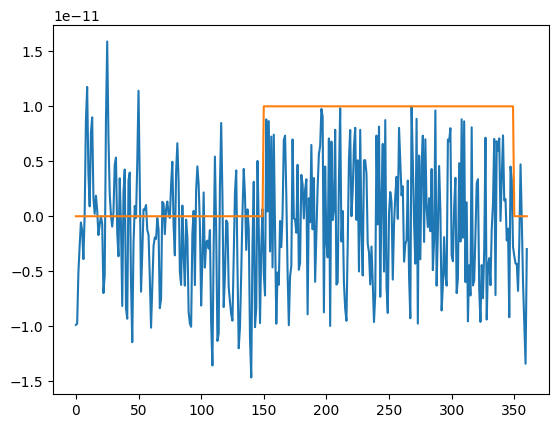

In [11]:
# X = X_original.copy()
n_noises = 1
X_zeros = np.zeros_like(X)
for i in range(n_noises):
    # start = np.random.randint(X.shape[-1])
    # dist = np.random.randint(X.shape[-1] - start)
    start = 150
    dist = 200
    t = np.arange(dist)
    g = gaussian(t, dist//2, 20)
    g_norm = (g - g.min())/(g.max() - g.min())
    X[:, :, start:start+dist] = 1*(2*1e-11*np.random.random((X.shape[0], 204, dist)) - 1e-11)+2e-13*g_norm
    # X[:, :, start:start+dist] = 1*(2*1e-11*np.random.random((939, 204, dist)) - 1e-11)
    X_zeros[:, :, start:start+dist] += 1e-11*np.ones((X.shape[0], 204, dist))
X_zeros = X_zeros[0, 0]
plt.plot(X[0, 0])
plt.plot(X_zeros)

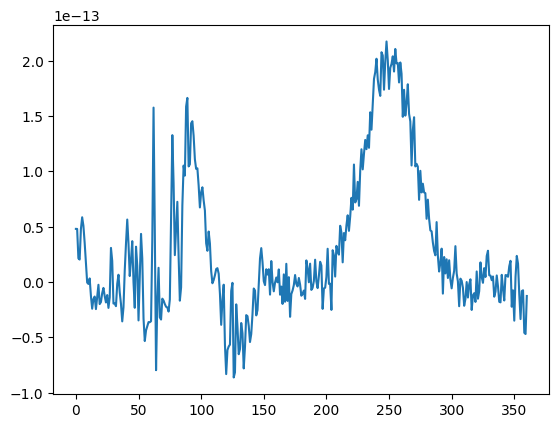

In [12]:
plt.plot(X.mean((0, 1)))

## Create dataset

In [13]:
#Specify import options
import_opt = dict(
    savepath='../TFR/',  # path where TFR files will be saved
    out_name='mne_sample_epochs',  # name of TFRecords files
    fs=600,
    input_type='trials',
    target_type='int',
    picks={'meg':'grad'},
    scale=True,  # apply baseline_scaling
    crop_baseline=True,  # remove baseline interval after scaling
    decimate=None,
    scale_interval=(0, 30),  # indices in time axis corresponding to baseline interval
    n_folds=5,  # validation set size set to 20% of all data
    overwrite=True,
    segment=False,
    test_set='holdout'
)


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords((X, Y), **import_opt)

dataset = mneflow.Dataset(meta, train_batch=100)

importing from tuple
input shapes: X: (940, 204, 361) targets: (940,)
(940,)
Preprocessing:
Scaling to interval 0.0 - 30.0
n: 940
Splitting into: 6 folds x 156
Preprocessed: (940, 1, 331, 204) (940, 1) folds: 6 x 156
Prepocessed sample shape: (1, 331, 204)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


## Specify parameters for SimpleNet

In [14]:
lf_params = dict(
    n_latent=8, #number of latent factors
    filter_length=50, #convolutional filter length in time samples
    nonlin = tf.nn.relu,#tf.keras.activations.linear,
    padding = 'SAME',
    pooling = 5,#5,#pooling factor
    stride = 5, #stride parameter for pooling layer
    pool_type='max',
    model_path = import_opt['savepath'],
    dropout = .5,
    l1_scope = ["weights"],
    l1=3e-3,
)

## Run SimpleNet

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 331, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 331, 8)
Setting reg for fc, to l1
Built: fc input: (None, 1, 67, 8)
Input shape: (1, 331, 204)
y_pred: (None, 8)
Initialization complete!
Class weights:  None
Epoch 1/25
100/100 - 3s - loss: 2.7379 - cat_ACC: 0.1837 - val_loss: 2.0617 - val_cat_ACC: 0.2320 - 3s/epoch - 31ms/step
Epoch 2/25
100/100 - 2s - loss: 1.8128 - cat_ACC: 0.3608 - val_loss: 1.6594 - val_cat_ACC: 0.4080 - 2s/epoch - 22ms/step
Epoch 3/25
100/100 - 2s - loss: 1.3067 - cat_ACC: 0.5261 - val_loss: 1.3353 - val_cat_ACC: 0.5120 - 2s/epoch - 23ms/step
Epoch 4/25
100/100 - 2s - loss: 0.9491 - cat_ACC: 0.6592 - val_loss: 1.1086 - val_cat_ACC: 0.6160 - 2s/epoch - 23ms/step
Epoch 5/25
100/100 - 2s - loss: 0.6965 - cat_ACC: 0.7631 - val_loss: 0.9767 - val_cat_ACC: 0.6560 - 2s/epoch - 23ms/step
Epoch 6/25
100/100 - 2s - loss: 0.5104 - cat_ACC: 0.8258 - val_loss: 0.9030 - val_cat_ACC: 0.6960 - 2s/epoch - 2

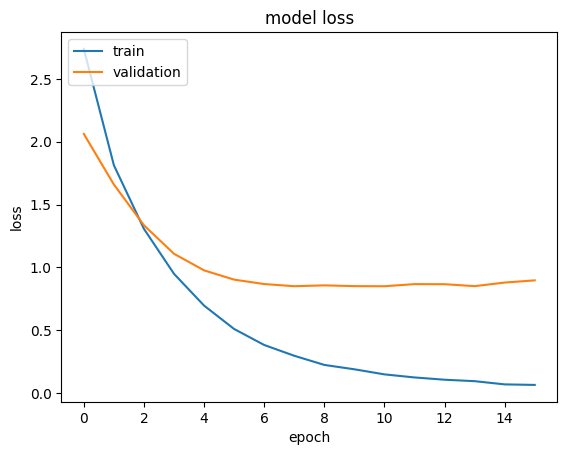

In [13]:
model = SimpleNet(dataset, lf_params)
model.build()
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

## Check accuracy

In [14]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_acc

0.8012820482254028

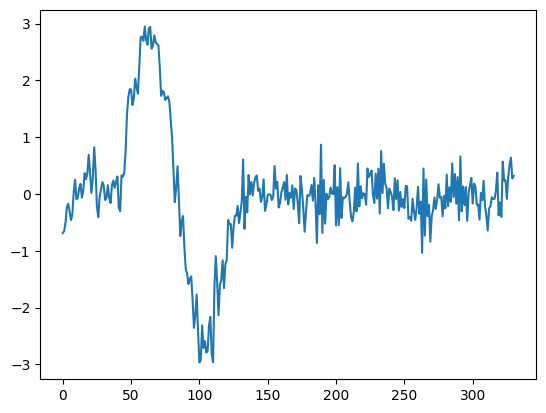

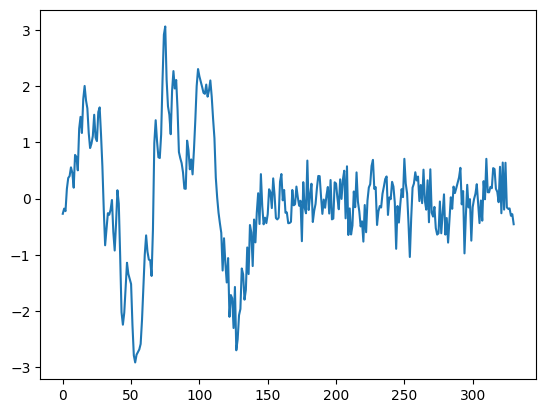

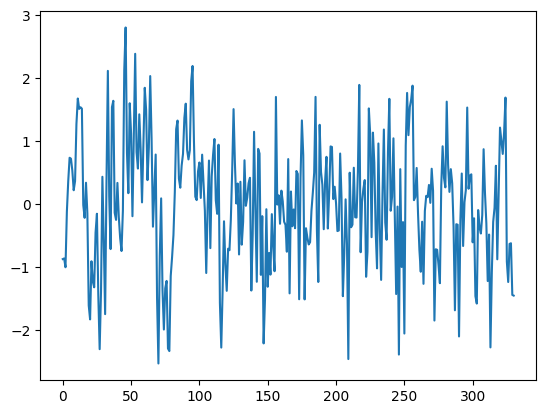

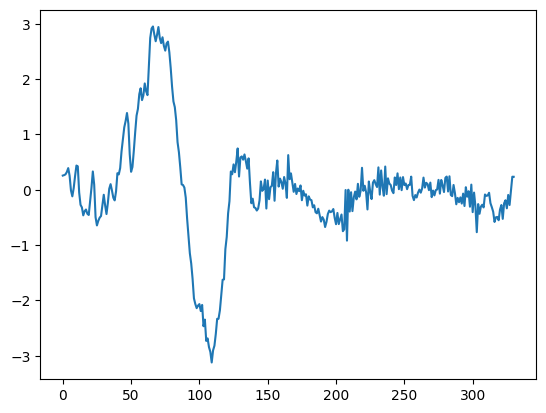

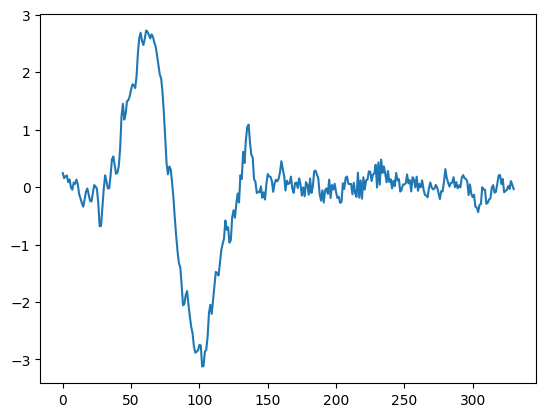

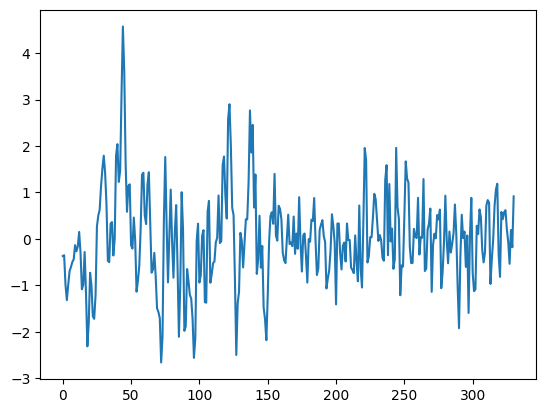

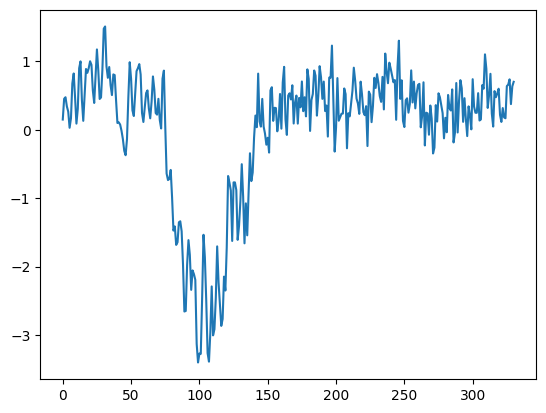

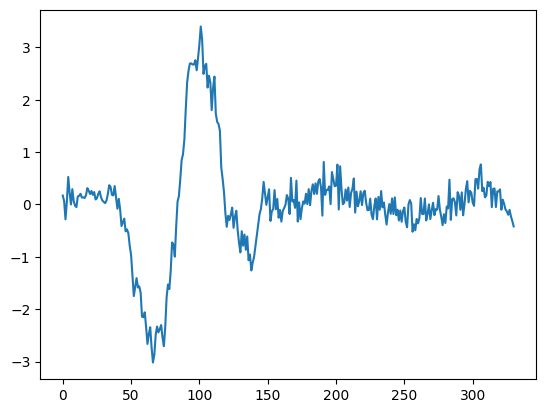

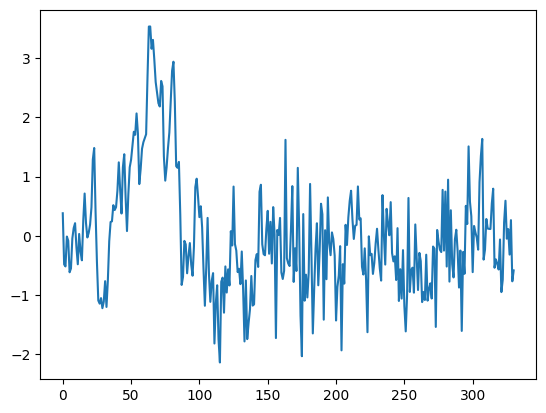

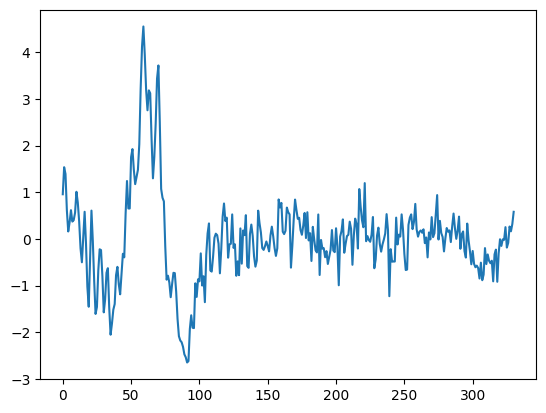

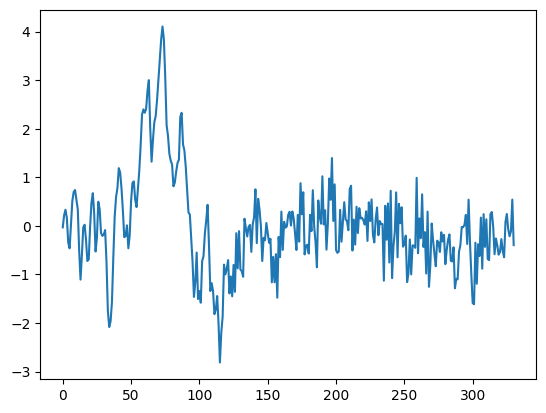

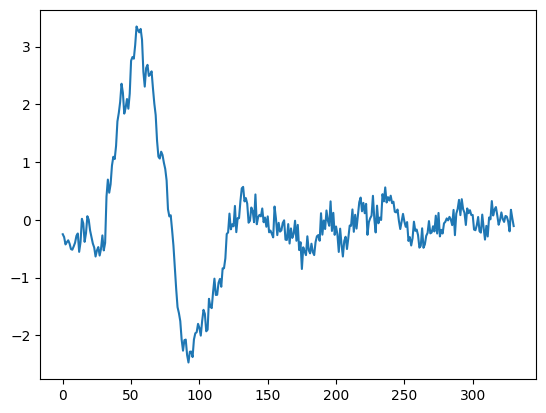

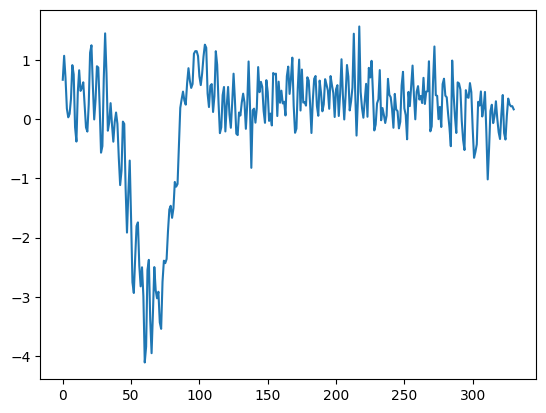

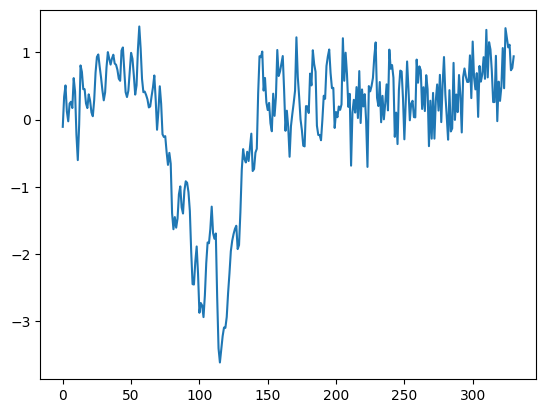

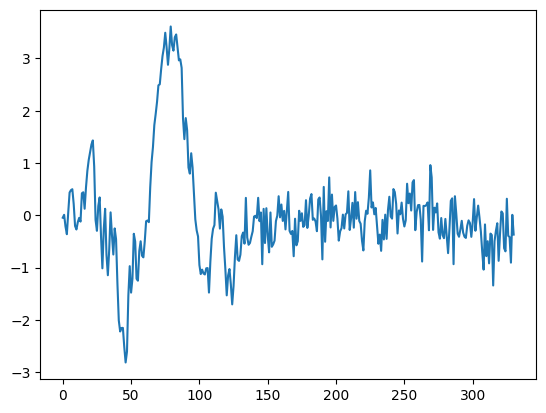

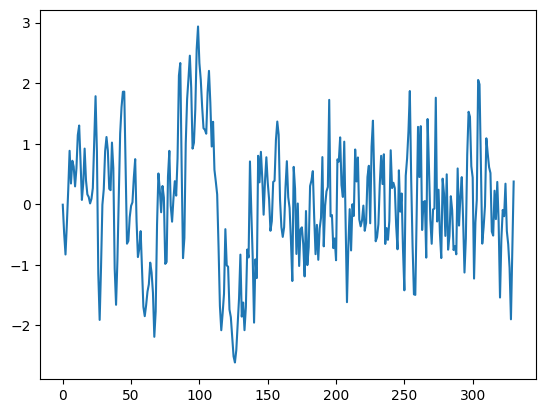

In [71]:
# envconv_out.shape
for i in range(model.specs['n_latent']):
    # plt.plot(sp.stats.zscore(X.numpy()[:, 0, :, :].mean((0, -1))))
    # plt.plot(sp.stats.zscore(envconv_out[:, 0, :, i].mean(0)))
    # plt.plot(sp.stats.zscore(np.abs(tconv_out[:, 0, :, i].mean(0))))
    # plt.plot(sp.stats.zscore(envconv_out[0, 0, :, i]))
    # plt.plot(sp.stats.zscore(tconv_out[0, 0, :, i]))
    plt.plot(sp.stats.zscore(tconv_out.mean(0)[0, :, i]))
    plt.show()

## Try upgraded version

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 331, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 331, 8)
Setting reg for fc, to l1
Built: fc input: (None, 1, 66, 8)
Input shape: (1, 331, 204)
y_pred: (None, 8)
Initialization complete!
Class weights:  None
Epoch 1/25
100/100 - 4s - loss: 1.9125 - cat_ACC: 0.2904 - val_loss: 1.4323 - val_cat_ACC: 0.4960 - 4s/epoch - 44ms/step
Epoch 2/25
100/100 - 3s - loss: 0.8784 - cat_ACC: 0.7210 - val_loss: 0.8345 - val_cat_ACC: 0.7840 - 3s/epoch - 27ms/step
Epoch 3/25
100/100 - 2s - loss: 0.4203 - cat_ACC: 0.9037 - val_loss: 0.6367 - val_cat_ACC: 0.8240 - 2s/epoch - 25ms/step
Epoch 4/25
100/100 - 2s - loss: 0.2450 - cat_ACC: 0.9606 - val_loss: 0.5574 - val_cat_ACC: 0.8400 - 2s/epoch - 25ms/step
Epoch 5/25
100/100 - 3s - loss: 0.1572 - cat_ACC: 0.9813 - val_loss: 0.5167 - val_cat_ACC: 0.8480 - 3s/epoch - 26ms/step
Epoch 6/25
100/100 - 3s - loss: 0.1117 - cat_ACC: 0.9912 - val_loss: 0.4910 - val_cat_ACC: 0.8480 - 3s/epoch - 2

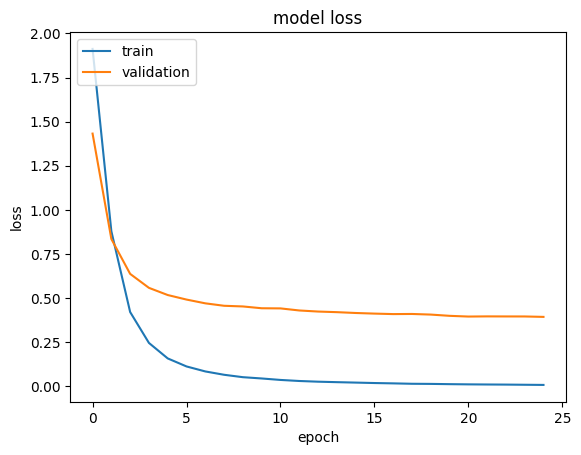

In [15]:
model = SimpleNetA(dataset, lf_params)
model.build()
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

In [16]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_acc

0.8653846383094788

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 331, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 331, 8)
Setting reg for fc, to l1
Built: fc input: (None, 66, 8)
Input shape: (1, 331, 204)
y_pred: (None, 8)
Initialization complete!
Class weights:  None
Epoch 1/25
100/100 - 100s - loss: 8.9486 - cat_ACC: 0.2107 - val_loss: 6.8834 - val_cat_ACC: 0.3111 - 100s/epoch - 997ms/step
Epoch 2/25
100/100 - 5s - loss: 5.5184 - cat_ACC: 0.4191 - val_loss: 4.4468 - val_cat_ACC: 0.5333 - 5s/epoch - 47ms/step
Epoch 3/25
100/100 - 5s - loss: 3.4492 - cat_ACC: 0.6132 - val_loss: 3.0696 - val_cat_ACC: 0.5704 - 5s/epoch - 46ms/step
Epoch 4/25
100/100 - 5s - loss: 2.2498 - cat_ACC: 0.7492 - val_loss: 2.2768 - val_cat_ACC: 0.6222 - 5s/epoch - 48ms/step
Epoch 5/25
100/100 - 5s - loss: 1.5607 - cat_ACC: 0.8303 - val_loss: 1.7901 - val_cat_ACC: 0.6667 - 5s/epoch - 47ms/step
Epoch 6/25
100/100 - 5s - loss: 1.1735 - cat_ACC: 0.8717 - val_loss: 1.4965 - val_cat_ACC: 0.6889 - 5s/epoch -

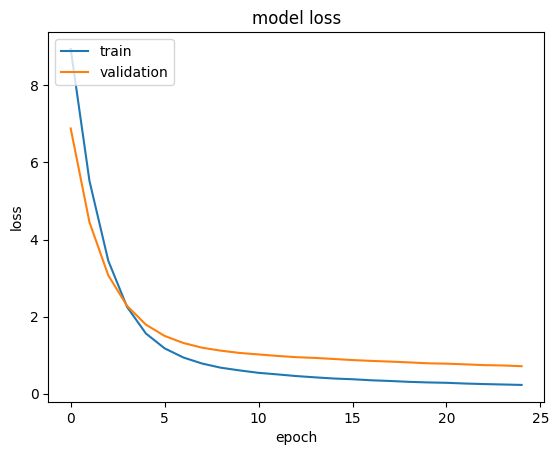

In [15]:
model = SimpleNetB(dataset, lf_params)
model.build()
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

In [17]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_acc

0.8205128312110901

In [19]:
ds = model.dataset.val
X, y = [row for row in ds.take(1)][0]
envconv_out = model.tconv(model.dmx(X))
pooled = list()
for i, pooling in enumerate(model.pool_list):
    pooled.append(pooling.timesel(
        tf.expand_dims(envconv_out[:, :, :, i], -1)
    )[1])

pooled = tf.stack(pooled, -1).numpy()
X_zeros_norm = (X_zeros - X_zeros.min())/(X_zeros.max() - X_zeros.min())
evo = X.numpy()[:, 0, :, :].mean(0)
# pooled.shape # n_epochs, 1, n_windows, n_branches

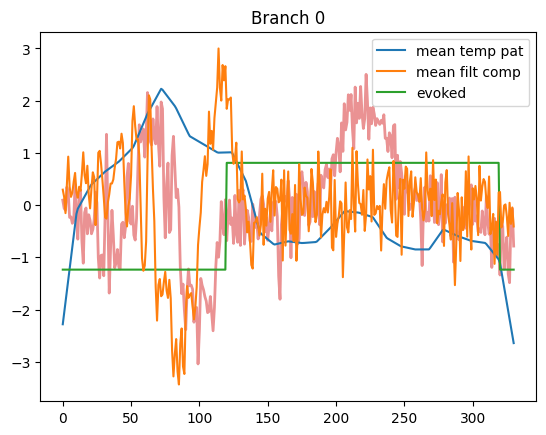

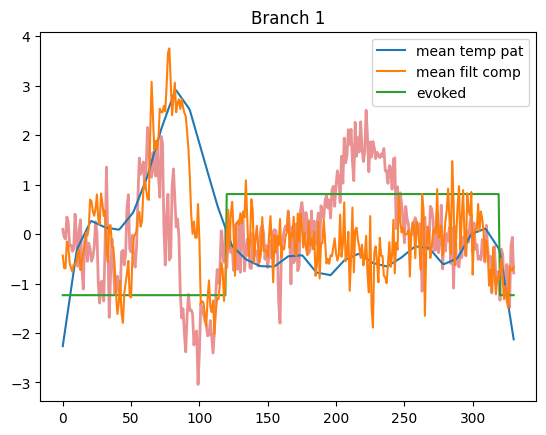

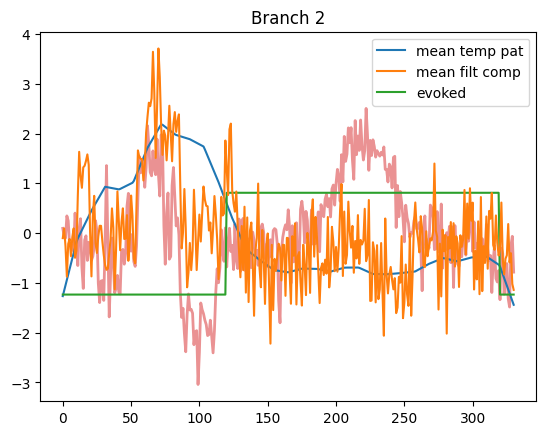

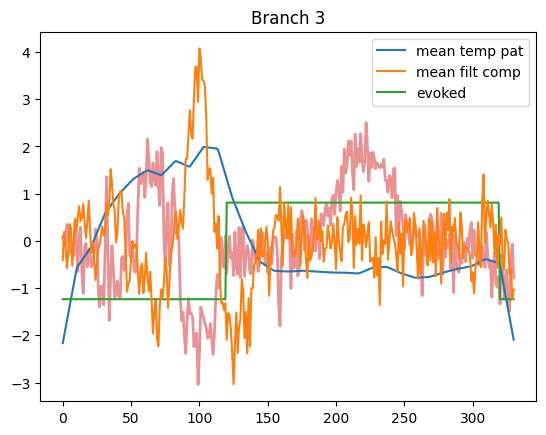

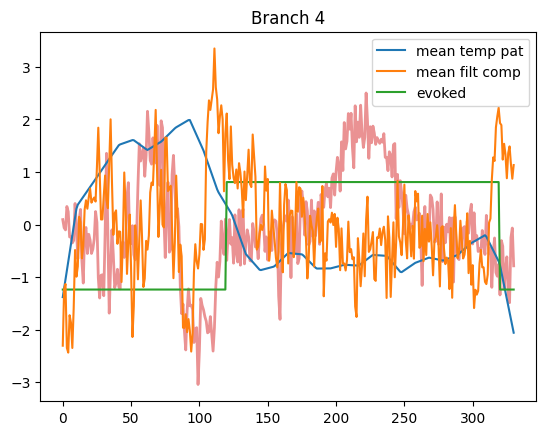

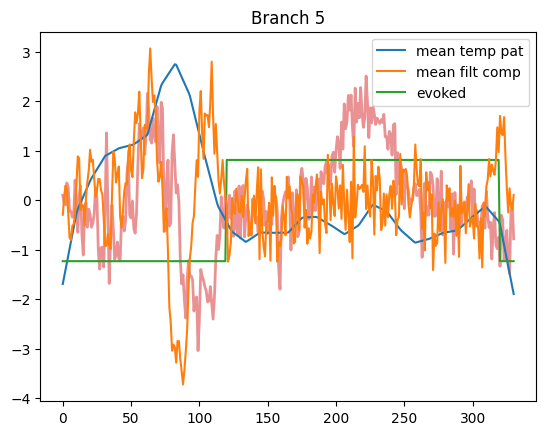

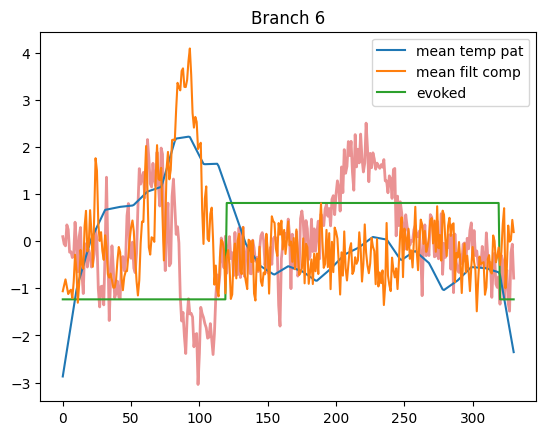

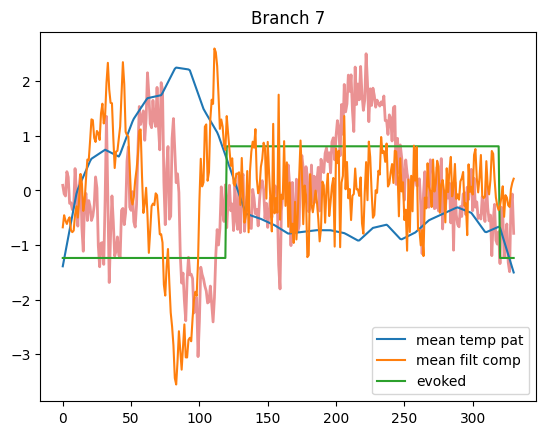

In [21]:
import scipy
filt_comps = np.squeeze(envconv_out.numpy())
z = scipy.stats.zscore
for i in range(pooled.shape[-1]):
    plt.plot(
        z(interpolate_sequence(pooled.mean(0)[0, :, i], 331)), zorder=1
    )
    plt.plot(
        z(filt_comps[:, :, i].mean(0))
    )
    plt.plot(z(X_zeros_norm[30:]), zorder=1) # 60 is baseline interval
    plt.plot(z(evo.mean(1)), zorder=0, alpha=0.5, linewidth=2.)
    plt.legend(['mean temp pat', 'mean filt comp', 'evoked'])
    plt.title(f'Branch {i}')
    plt.show()

In [39]:
from alltools.machine_learning import one_hot_decoder, one_hot_encoder

In [54]:
y = one_hot_decoder(y)

In [70]:
X.shape

TensorShape([135, 1, 331, 204])

3 17


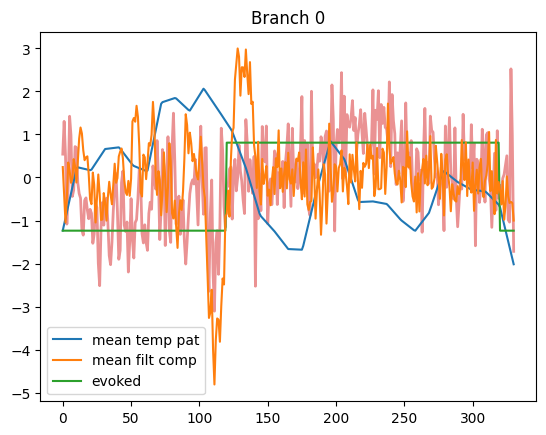

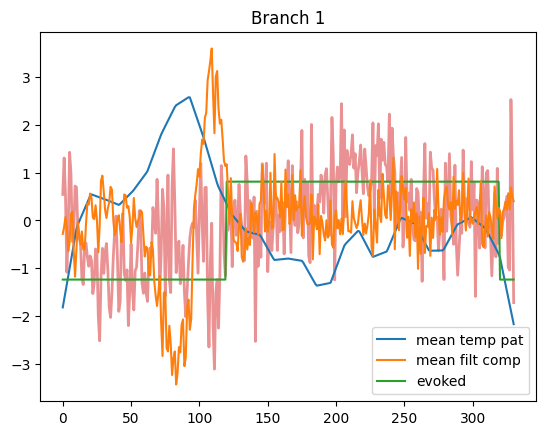

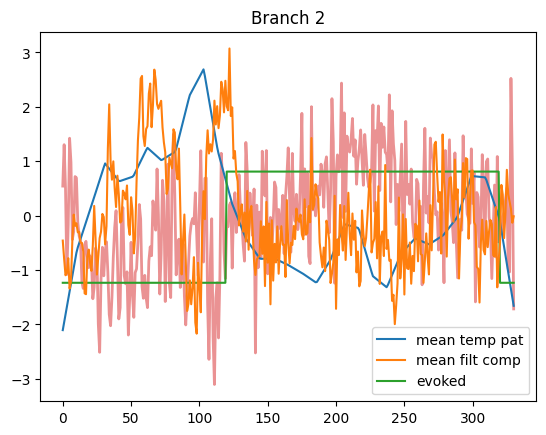

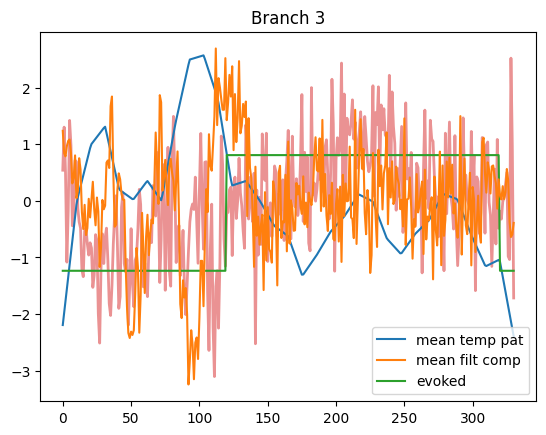

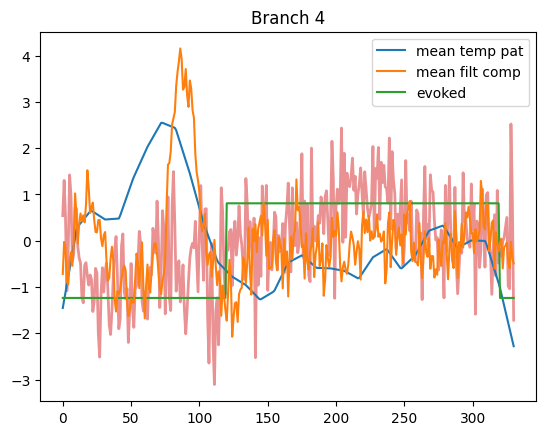

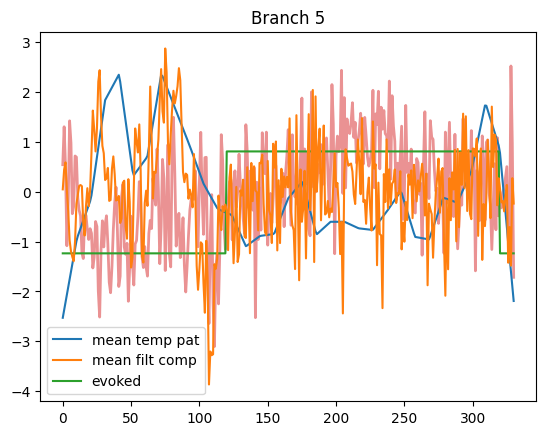

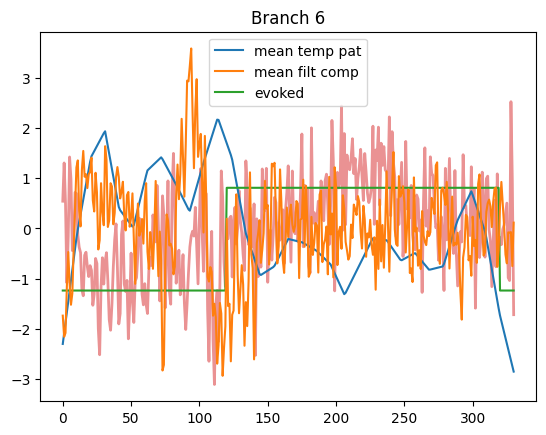

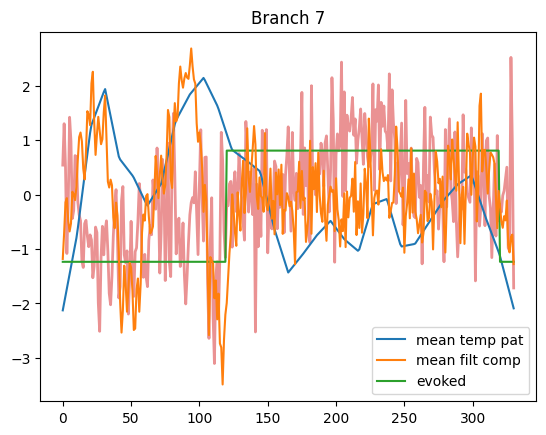

In [81]:
filt_comps = np.squeeze(envconv_out.numpy())
z = scipy.stats.zscore
n_epoch = 3

print(n_epoch, len(np.where(y == n_epoch)[0]))
for i in range(pooled.shape[-1]):
    plt.plot(
        z(interpolate_sequence(pooled[np.where(y == n_epoch)[0], 0, :, i].mean(0), 331)), zorder=1
    )
    plt.plot(
        z(filt_comps[np.where(y == n_epoch)[0], :, i].mean(0))
    )
    plt.plot(z(X_zeros_norm[30:]), zorder=1) # 60 is baseline interval
    plt.plot(z(X.numpy()[np.where(y == n_epoch)[0], 0, :, :].mean((0, -1))), zorder=0, alpha=0.5, linewidth=2.)
    plt.legend(['mean temp pat', 'mean filt comp', 'evoked'])
    plt.title(f'Branch {i}')
    plt.show()

In [9]:
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from utils.models import SimpleNetA
from deepmeg.params import compute_temporal_parameters,\
    compute_waveforms, compute_compression_parameters,\
    WaveForms, SpatialParameters, TemporalParameters, CompressionParameters

## Check accuracy

In [11]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_acc

0.8461538553237915

In [12]:
model.compute_patterns(meta['test_paths'])
nt = model.dataset.h_params['n_t']
time_courses = np.squeeze(model.lat_tcs.reshape([-1, model.specs['n_latent'], nt]))
time_courses = np.transpose(time_courses, (1, 0, 2))
time_courses_filt = np.squeeze(model.lat_tcs_filt.reshape([-1, model.specs['n_latent'], nt]))
time_courses_filt = np.transpose(time_courses_filt, (1, 0, 2))
times = (1 / float(model.dataset.h_params['fs'])) *\
    np.arange(model.dataset.h_params['n_t'])
patterns = model.patterns.copy()
model.compute_patterns(meta['test_paths'], output='filters', relevances=False)
filters = model.patterns.copy()
franges, finputs, foutputs, fresponces, fpatterns = compute_temporal_parameters(model)
induced, induced_filt, times, time_courses = compute_waveforms(model)
temp_relevance_loss, compression_weights = compute_compression_parameters(model)

order = model.branch_relevance_loss
wf = WaveForms(time_courses.mean(1), time_courses_filt.mean(1), induced, induced_filt, times, time_courses)
sp_ = SpatialParameters(patterns, filters)
tp = TemporalParameters(franges, finputs, foutputs, fresponces, fpatterns)
cp = CompressionParameters(
    temp_relevance_loss,
    compression_weights
)

Processing branch 0...	DONE
Processing branch 1...	DONE
Processing branch 2...	DONE
Processing branch 3...	DONE
Processing branch 4...	DONE
Processing branch 5...	DONE
Processing branch 6...	DONE
Processing branch 7...	DONE
Processing branch 8...	DONE
Processing branch 9...	DONE
Processing branch 10...	DONE
Processing branch 11...	DONE
Processing branch 12...	DONE
Processing branch 13...	DONE
Processing branch 14...	DONE
Processing branch 15...	DONE


In [20]:
import scipy as sp
import mne
import matplotlib.pyplot as plt
import matplotlib as mp
import matplotlib as mpl
import copy
import numpy as np
from typing import Optional, Union, NoReturn
from dataclasses import dataclass
from matplotlib.widgets import Button
from collections.abc import Iterable

In [22]:
def plot_spatial_weights(
    spatial_parameters: SpatialParameters,
    temporal_parameters: TemporalParameters,
    waveforms: WaveForms,
    info: mne.Info,
    compressions: Optional[CompressionParameters] = None,
    summarize: Optional[Union[str, list[float]]] = 'sum',
    title: Optional[str] = 'Spatial Patterns',
    temp_params: Optional[list[str]] = ['input', 'response', 'output'],
    show: Optional[bool] = True,
    logscale: Optional[bool] = False,
    shift_induced_times: Optional[bool | float] = False,
    filtered_induced: Optional[bool] = False
) -> Union[mp.figure.Figure, NoReturn]:

    mp.use('Qt5Agg')

    def init_canvas(ax01, ax02, ax1, ax2):
        ax01.axes.xaxis.set_visible(False)
        ax01.axes.yaxis.set_visible(False)
        ax02.axes.xaxis.set_visible(False)
        ax02.axes.yaxis.set_visible(False)

        ax01.spines['right'].set_visible(False)
        ax01.spines['left'].set_visible(False)
        ax01.spines['top'].set_visible(False)
        ax01.spines['bottom'].set_visible(False)
        ax02.spines['right'].set_visible(False)
        ax02.spines['left'].set_visible(False)
        ax02.spines['top'].set_visible(False)
        ax02.spines['bottom'].set_visible(False)

        ax1.spines['right'].set_visible(False)
        ax1.set_xlabel('Channels')
        ax1.set_ylabel('Latent Sources')
        ax1.spines['left'].set_alpha(0.2)
        ax1.spines['bottom'].set_alpha(0.2)
        ax1.spines['top'].set_alpha(0.2)
        ax1.axes.yaxis.set_alpha(0.2)
        ax1.set_yticks(np.arange(y_lim))
        ax1.set_yticklabels(labels=[i + 1 for i in sorting_callback.sorted_indices])
        ax1.tick_params(axis='both', which='both', length=5, color='#00000050')

        ax2.axes.yaxis.set_visible(False)
        ax2.axes.xaxis.set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['top'].set_alpha(0.2)
        ax2.spines['right'].set_alpha(0.2)
        ax2.spines['bottom'].set_alpha(0.2)

    class SortingCallback:

        def __init__(
            self,
            button: Button,
            fig: plt.Figure,
            bar_ax: mp.axes.Axes,
            imshow_ax: mp.axes.Axes,
            indices: list[int]
        ):
            self._button = button
            self._fig = fig
            self._bar_ax = bar_ax
            self._imshow_ax = imshow_ax
            self._event = None
            self._sorted_indices = indices

        def __call__(self, event):
            self._event = event

            if '▼' in self._button.label._text:
                self.decreasing()
            else:
                self.increasing()

        @property
        def sorted_indices(self):
            return self._sorted_indices

        @sorted_indices.setter
        def sorted_indices(self, value):
            raise AttributeError('Impossible to set indices directly')

        def increasing(self):
            self._button.label.set_text('Sort ▼')
            self._sorted_indices = sorted(range(len(sums)), key=lambda k: sums[k], reverse=True)
            self.update()

        def decreasing(self):
            self._button.label.set_text('Sort ▲')
            self._sorted_indices = sorted(range(len(sums)), key=lambda k: sums[k])
            self.update()

        def update(self):
            self._imshow_ax.clear()
            self._imshow_ax.imshow(data.T[self._sorted_indices, :], aspect='auto', cmap='RdBu_r')
            self._bar_ax.clear()
            self._bar_ax.barh(
                range(len(sums)),
                np.abs(sums)[self._sorted_indices], color=colors[self._sorted_indices],
                height=.9
            )
            init_canvas(ax01, ax02, ax1, ax2)
            self._fig.canvas.draw()

    def onclick(event):
        flim = 70
        crop = .05
        shift = shift_induced_times

        if ax1.lines:

            for i in range(len(ax1.lines)):
                ax1.lines.remove(ax1.lines[i])

        _, iy = event.xdata, event.ydata

        if (event.inaxes == ax1 or event.inaxes == ax2) \
            and event.xdata is not None \
            and event.ydata is not None \
            and 0 < event.xdata < x_lim \
                and -.5 < event.ydata < y_lim:
            iy = int(np.rint(iy))
            induced = waveforms.induced.copy()[
                sorting_callback.sorted_indices[iy],
                :flim,
                :
            ] if not filtered_induced else\
                waveforms.induced_filt.copy()[
                sorting_callback.sorted_indices[iy],
                :flim,
                :
            ]
            crop *= induced.shape[1] / 2

            for i, ind_course in enumerate(induced):
                induced[i] /= ind_course.mean()

            color = colors[sorting_callback._sorted_indices[iy]]
            line = mp.lines.Line2D([0, x_lim], [iy, iy], color=color, linewidth=2.56*data.shape[0]/data.shape[1], alpha=.4)
            ax1.add_line(line)
            fig1.canvas.draw()
            fig2 = plt.figure(constrained_layout=False)
            if compressions is None:
                gs2 = fig2.add_gridspec(
                    nrows=10,
                    ncols=3,
                    bottom=.1,
                    wspace=.05,
                    hspace=.1
                )
                ax21 = fig2.add_subplot(gs2[:, :-1])
                ax22 = fig2.add_subplot(gs2[0:5, -1])
                ax23 = fig2.add_subplot(gs2[5:, -1])
            else:
                gs2 = fig2.add_gridspec(
                    nrows=10,
                    ncols=16,
                    bottom=.1,
                    wspace=.05,
                    hspace=.1
                )
                ax21 = fig2.add_subplot(gs2[0:4, :-8])
                ax22 = fig2.add_subplot(gs2[0:5, -7:])
                ax23 = fig2.add_subplot(gs2[5:, -7:])
                ax24 = fig2.add_subplot(gs2[5:, :-9])

            plot_patterns(
                data,
                info,
                sorting_callback.sorted_indices[iy],
                ax21,
                name_format=''
            )
            ax22_t = ax22.twinx()
            evoked = waveforms.evoked[sorting_callback.sorted_indices[iy]] if not filtered_induced else\
                waveforms.evoked_filt[sorting_callback.sorted_indices[iy]]
            ax22_t.plot(
                sp.stats.zscore(evoked),
                '#454545'
            )
            pos = ax22.imshow(
                induced,
                cmap='RdBu_r',
                origin='lower'
            )
            cb = fig2.colorbar(
                pos,
                ax=ax22,
                pad=0.12,
                orientation='horizontal',
                aspect=75,
                fraction=.12
            )
            ax22.set_aspect('auto')
            ax22_t.set_aspect('auto')
            # ax22_t.set_ylim(top=1, bottom=-1)
            legend = list()
            for param in temp_params:
                match param:
                    case 'input':
                        legend.append('Filter input')
                        ax23.plot(
                            temporal_parameters.franges,
                            sp.stats.zscore(temporal_parameters.finputs[sorting_callback.sorted_indices[iy]]),
                            color='tab:blue'
                        )
                    case 'output':
                        legend.append('Filter output')
                        ax23.plot(
                            temporal_parameters.franges,
                            sp.stats.zscore(temporal_parameters.foutputs[sorting_callback.sorted_indices[iy]]),
                            color='tab:orange'
                        )
                    case 'response':
                        legend.append('Filter response')
                        ax23.plot(
                            temporal_parameters.franges,
                            sp.stats.zscore(
                                temporal_parameters.fresponces[sorting_callback.sorted_indices[iy]]
                            ),
                            color='tab:green'
                        )
                    case 'pattern':
                        legend.append('Filtering pattern')
                        ax23.plot(
                            sp.stats.zscore(
                                temporal_parameters.fpatterns[sorting_callback.sorted_indices[iy]]
                            ),
                            color='tab:pink'
                        )
                    case _:
                        raise NotImplementedError(f'Temporal parameter {param} is not implemented')

            ax22_t.set_ylabel('Amplitude', labelpad=12.5, rotation=270)
            ax22_t.spines['top'].set_alpha(.2)
            ax22_t.spines['right'].set_alpha(.2)
            ax22_t.spines['left'].set_alpha(.2)
            ax22_t.spines['bottom'].set_alpha(.2)
            ax22_t.tick_params(axis='both', which='both', length=5, color='#00000050')
            ax22.spines['top'].set_alpha(.2)
            ax22.spines['right'].set_alpha(.2)
            ax22.spines['left'].set_alpha(.2)
            ax22.spines['bottom'].set_alpha(.2)
            ax22.tick_params(axis='both', which='both', length=5, color='#00000050')
            cb.outline.set_color('#00000020')
            cb.ax.tick_params(axis='both', which='both', length=5, color='#00000050')
            times = np.unique(np.round(waveforms.times, 1))
            ranges = np.linspace(0, len(waveforms.times), len(times)).astype(int)

            if shift is True:
                times = np.round(times - times.mean(), 2)
            elif isinstance(shift, (int, float)):
                times = np.round(times - shift, 2)

            ax22.set_xticks(ranges)
            ax22.set_xticklabels(times)
            ax22.set_xlabel('Time (s)')
            ax22.set_ylabel('Frequency (Hz)')
            ax23.legend(legend, loc='upper right')
            ax23.spines['top'].set_alpha(.2)
            ax23.spines['right'].set_alpha(.2)
            ax23.spines['left'].set_alpha(.2)
            ax23.spines['bottom'].set_alpha(.2)
            ax23.tick_params(axis='both', which='both', length=5, color='#00000050')
            ax23.set_xlabel('Frequency (Hz)')
            ax23.set_ylabel('Amplitude (z-score)')
            # ax23.set_ylim(top=1.2)
            ax23.set_xlim([0, 70])
            ax22_t.set_xlim([2 * crop, len(waveforms.times) - 2 * crop])

            if logscale:
                ax23.set_yscale('log')

            if compressions:
                ax24.spines['top'].set_alpha(.2)
                ax24.spines['right'].set_alpha(.2)
                ax24.spines['left'].set_alpha(.2)
                ax24.spines['bottom'].set_alpha(.2)
                evo = sp.stats.zscore(waveforms.evoked_filt[sorting_callback.sorted_indices[iy]])
                ax24.plot(
                    evo
                )
                loss_estimate = sp.stats.zscore(compressions.loss_estimate[sorting_callback.sorted_indices[iy]])
                ax24.plot(
                    moving_average(loss_estimate)
                )
                ax24.set_xticks(ranges)
                ax24.set_xticklabels(times)
                ax24.set_xlabel('Time (s)')
                ax24.set_ylabel('Amplitude (z-score)')
                ax24.tick_params(axis='both', which='both', length=5, color='#00000050')
                ax24.legend(
                    [
                        'Filtered component evoked',
                        'Loss-based estimate'
                    ],
                    loc='upper right'
                )

            fig2.suptitle(f'Latent source {sorting_callback.sorted_indices[iy] + 1}')
            plt.show()

    data = spatial_parameters.patterns.copy()
    x_lim, y_lim = data.shape
    fig1 = plt.figure()
    fig1.suptitle(title)
    gs = fig1.add_gridspec(2, 2, hspace=0, wspace=0, width_ratios=[1, .1], height_ratios=[.025, 1])

    (ax01, ax02), (ax1, ax2) = gs.subplots(sharex='col', sharey='row')

    if summarize == 'sum':
        sums = np.sum(data, axis=0)
    elif summarize == 'sumabs':
        sums = np.sum(np.abs(data), axis=0)
    elif summarize == 'abssum':
        sums = np.abs(np.sum(data, axis=0))
    elif isinstance(summarize, Iterable) and len(summarize) == y_lim:
        sums = np.array(summarize)
    else:
        raise NotImplementedError(
            f'The "{summarize}" method not implemented. '
            'Available methods: "sum", "sumabs", "abssum"'
        )
    colors = np.array(['#f2827a' if sum_ >= 0 else '#8bbae5' for sum_ in sums])

    sort_button = Button(ax02, 'Sort')
    sorting_callback = SortingCallback(
        sort_button,
        fig1,
        ax2,
        ax1,
        sorted(range(len(sums)), reverse=False)
    )
    sort_button.on_clicked(sorting_callback)

    init_canvas(ax01, ax02, ax1, ax2)

    ax1.imshow(data.T, aspect='auto', cmap='RdBu_r')
    ax2.barh(sorting_callback.sorted_indices, np.abs(sums), color=colors, height=.9)

    cid1 = fig1.canvas.mpl_connect('button_press_event', onclick)
    cid2 = fig1.canvas.mpl_connect('close_event', lambda e: fig1.canvas.mpl_disconnect(cid1))

    if show:
        plt.show()

    fig1.canvas.mpl_disconnect(cid2)

    return fig1

In [34]:
time_courses_filtered = model.lat_tcs_filt
selected_time_course_plot = time_courses_filtered.reshape(
    [-1, model.dataset.h_params['n_t']]
)

array([ 4, 13,  5,  8, 14, 10, 11,  0, 15,  6,  2,  9,  1,  3,  7, 12])

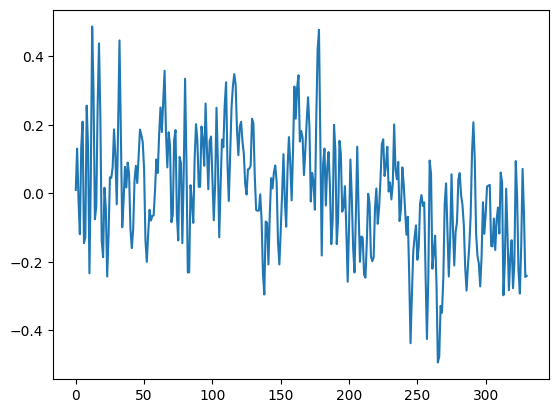

In [36]:
plt.plot(wf.evoked[np.argsort(order)[0]])

/tmp/ipykernel_1087476/4128298007.py:312: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if summarize == 'sum':
/tmp/ipykernel_1087476/4128298007.py:314: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif summarize == 'sumabs':
/tmp/ipykernel_1087476/4128298007.py:316: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif summarize == 'abssum':


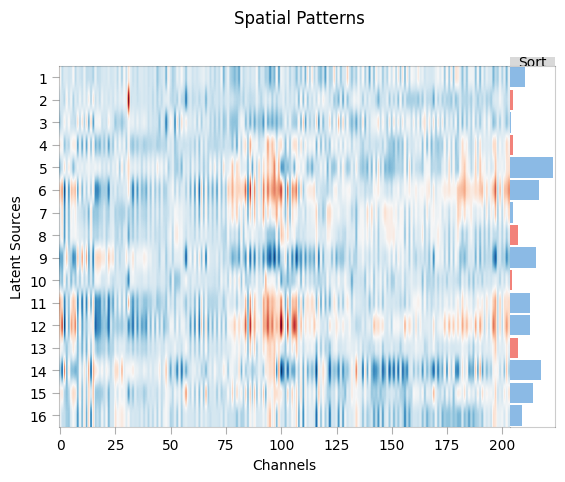

In [43]:
%matplotlib qt
from deepmeg.viz import plot_patterns
from deepmeg.params import moving_average
plot_spatial_weights(
    sp_,
    tp,
    wf,
    epochs.info,
    cp,
    summarize=order,
    logscale=False,
    temp_params=['input', 'output', 'response', 'pattern'],
    # shift_induced_times = -epochs.times[0],
    filtered_induced=False
)

In [14]:
model.compute_patterns()

Computing patterns: No path specified, using validation dataset (Default)
Processing branch 0...	DONE, 331
Processing branch 1...	DONE, 331
Processing branch 2...	DONE, 331
Processing branch 3...	DONE, 331
Processing branch 4...	DONE, 331
Processing branch 5...	DONE, 331
Processing branch 6...	DONE, 331
Processing branch 7...	DONE, 331
Processing branch 8...	DONE, 331
Processing branch 9...	DONE, 331
Processing branch 10...	DONE, 331
Processing branch 11...	DONE, 331
Processing branch 12...	DONE, 331
Processing branch 13...	DONE, 331
Processing branch 14...	DONE, 331
Processing branch 15...	DONE, 331


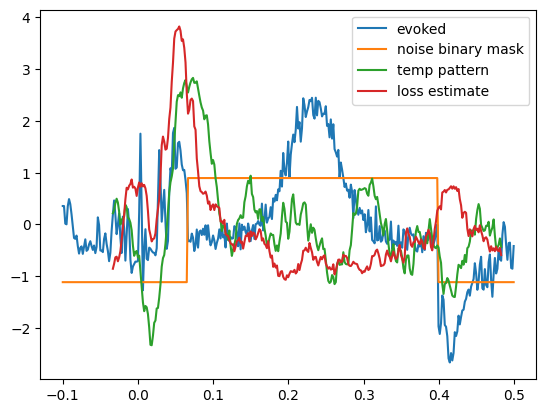

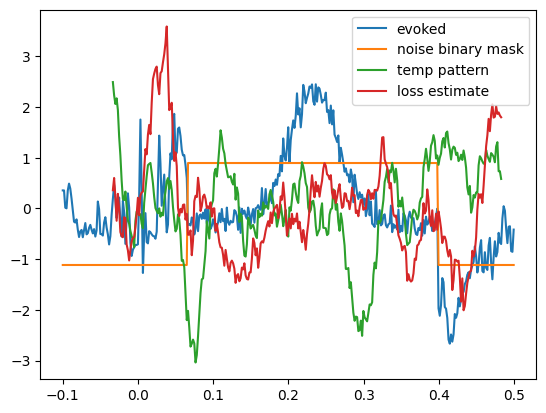

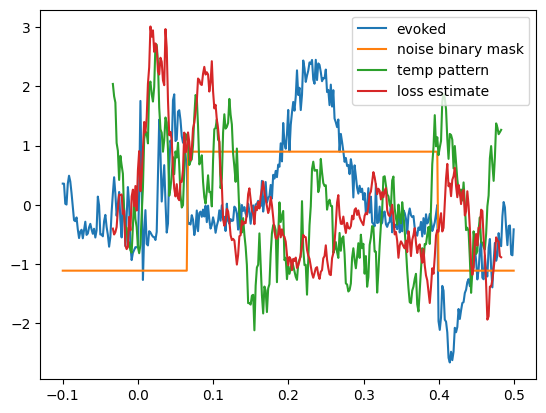

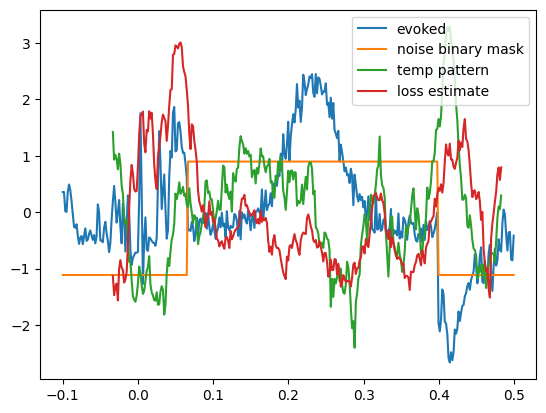

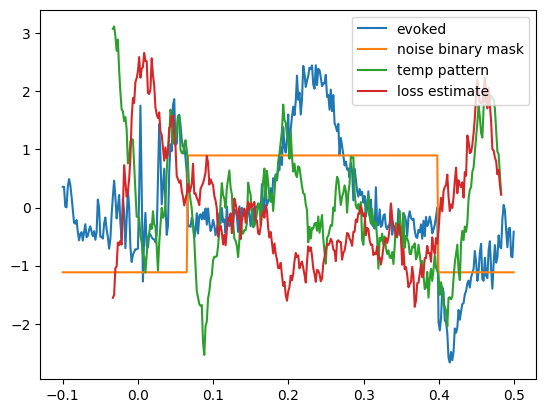

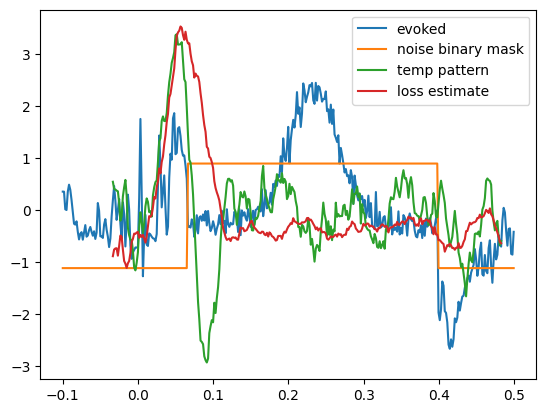

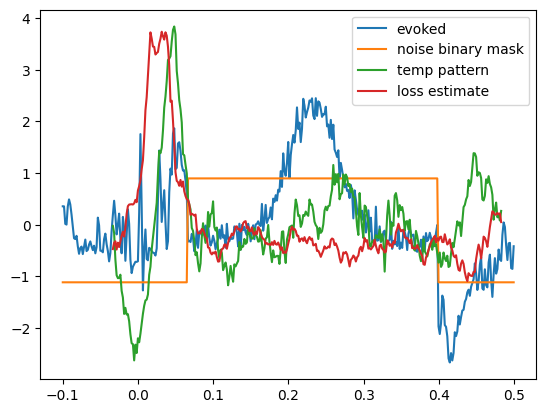

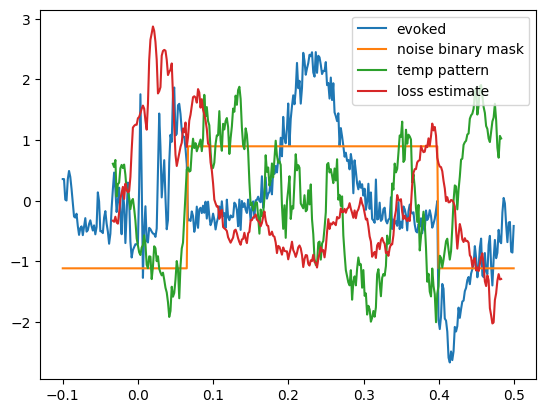

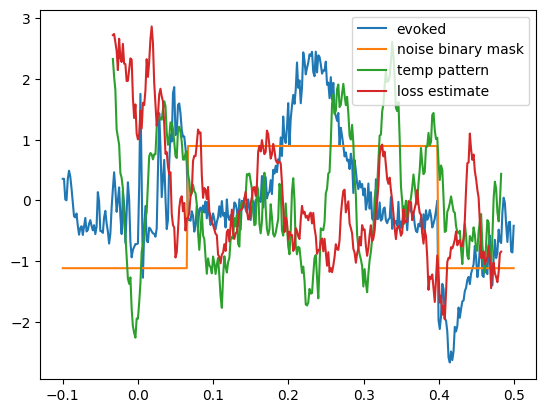

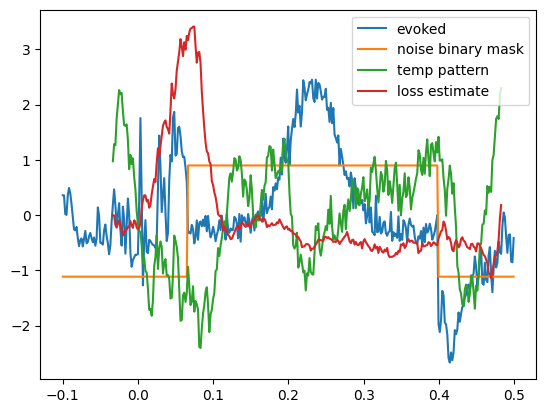

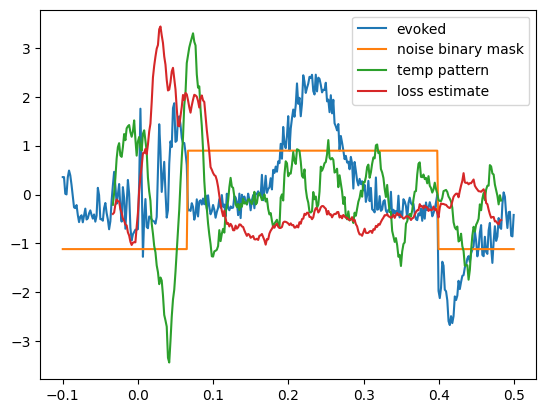

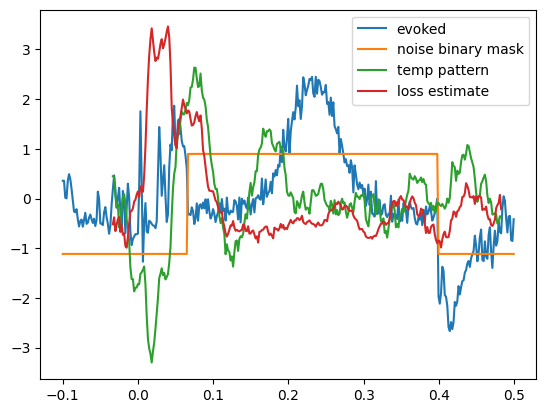

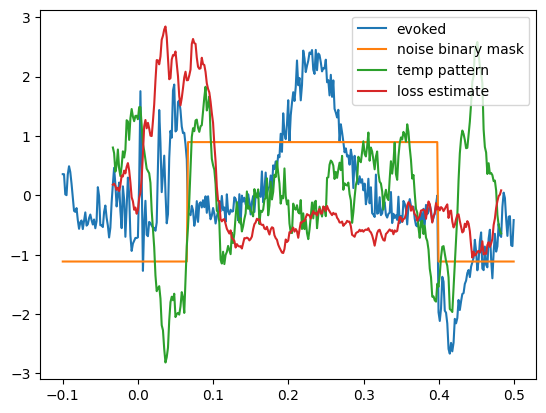

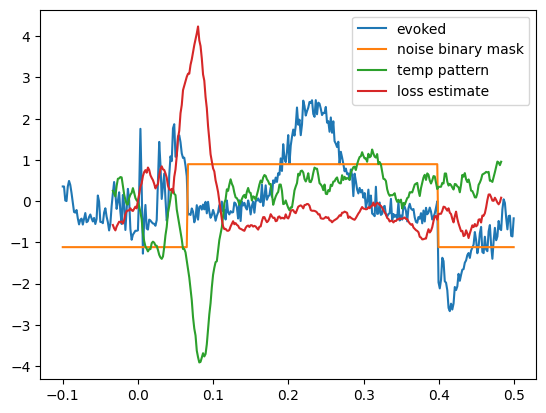

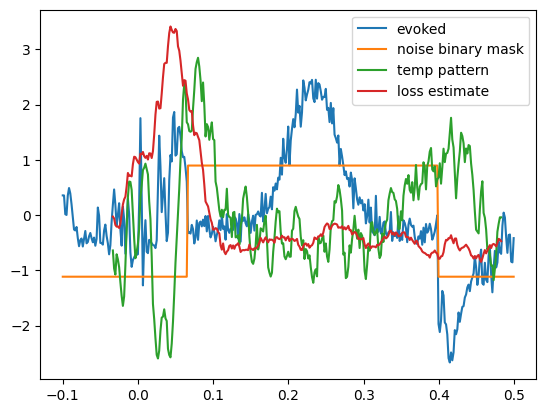

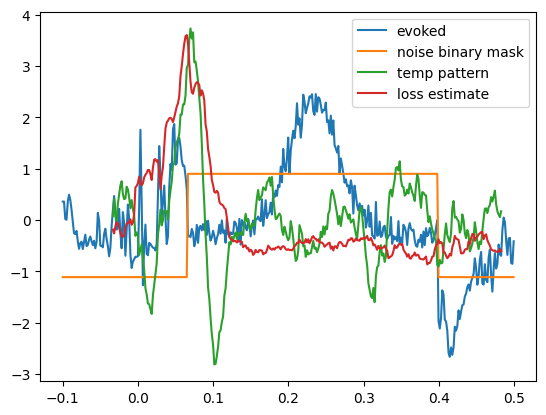

In [53]:
for branch_num in range(model.specs['n_latent']):
    plt.plot(epochs.times, sp.stats.zscore(X.mean((0, 1))))
    plt.plot(epochs.times, sp.stats.zscore(X_zeros))
    sorting = np.argsort(model.branch_relevance_loss)[::-1]
    ec = np.real(eigencentrality(np.cov(model.pool_list[sorting[branch_num]].weights[0].numpy())))
    from deepmeg.params import moving_average
    plt.plot(
        epochs.times,
        np.append(
            [None for _ in range(len(epochs.times) - len(ec))],
            moving_average(sp.stats.zscore(ec))
        )
    )
    temp_course = model.temp_relevance_loss[sorting[branch_num]]
    plt.plot(
        epochs.times,
        np.append(
            [None for _ in range(len(epochs.times) - len(ec))],
            moving_average(sp.stats.zscore(temp_course))
        )
    )

    plt.legend(
        [
            'evoked',
            'noise binary mask',
            'temp pattern',
            'loss estimate'
        ],
        loc="upper right"
    )
    plt.show()


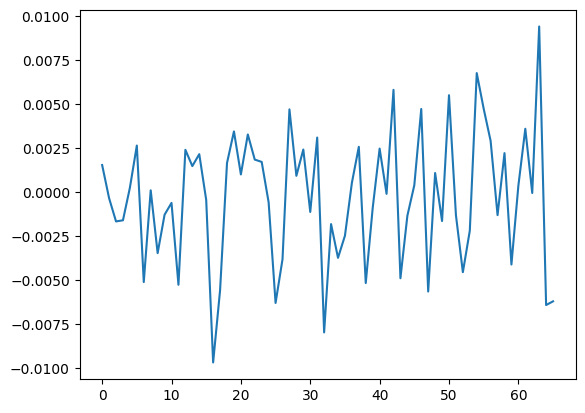

In [47]:
data = model.pool_list[sorting[branch_num]].weights[0].numpy()

plt.plot(data.mean(0))

In [37]:
def plot_branch(
    self,
    branch_num: int,
    info: mne.Info,
    params: Optional[list[str]] = ['input', 'output', 'response']
):
    info.__setstate__(dict(_unlocked=True))
    info['sfreq'] = 1.
    sorting = np.argsort(self.branch_relevance_loss)[::-1]
    data = self.patterns[:, sorting]
    filters = self.filters[:, sorting]
    relevances = self.branch_relevance_loss - self.branch_relevance_loss.min()
    relevance = sorted([np.round(rel/relevances.sum(), 2) for rel in relevances], reverse=True)[branch_num]
    self.fake_evoked = evoked.EvokedArray(data, info, tmin=0)
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1)
    fig.tight_layout()

    self.fs = self.dataset.h_params['fs']

    out_filter = filters[:, branch_num]
    _, psd = sl.welch(self.lat_tcs[branch_num], fs=self.fs, nperseg=self.fs * 2)
    w, h = (lambda w, h: (w, h))(*sl.freqz(out_filter, 1, worN=self.fs))
    frange = w / np.pi * self.fs / 2
    z = lambda x: (x - x.mean())/x.std()

    for param in params:
        if param == 'input':
            finput = psd[:-1]
            finput = z(finput)
            ax2.plot(frange, finput - finput.min(), color='tab:blue')
        elif param == 'output':
            foutput = np.real(finput * h * np.conj(h))
            foutput = z(foutput)
            ax2.plot(frange, foutput - foutput.min(), color='tab:orange')
        elif param == 'response':
            fresponce = np.abs(h)
            fresponce = z(fresponce)
            ax2.plot(frange, fresponce - fresponce.min(), color='tab:green')
        elif param == 'pattern':
            fpattern = finput * np.abs(h)
            fpattern = z(fpattern)
            ax2.plot(frange, fpattern - fpattern.min(), color='tab:pink')

    kernel_size = 20
    kernel = np.ones(kernel_size) / kernel_size
    ax2.legend([param.capitalize() for param in params])
    ax2.set_xlim(0, 100)
    time_courses_filtered = self.lat_tcs_filt
    # time_courses_env = np.zeros_like(time_courses_filtered)
    # kern = np.squeeze(self.envconv.filters.numpy()).T
    # conv = np.abs(np.convolve(time_courses_filtered[sorting[branch_num], :], kern[sorting[branch_num], :], mode="same"))
    # time_courses_env[sorting[branch_num], :] = conv
    selected_time_course_plot = time_courses_filtered.reshape(
        [-1, self.specs['n_latent'], self.dataset.h_params['n_t']]
    )

    selected_w =  self.pool_list[sorting[branch_num]].weights[0].numpy()
    selected_temp_relevance_loss = self.temp_relevance_loss[sorting[branch_num]]

    kernel_size = 20
    kernel = np.ones(kernel_size) / kernel_size
    data = np.cov(selected_w)

    #evoked
    ax3.plot(
        np.arange(0, self.dataset.h_params['n_t']/self.fs, 1./self.fs),
        sp.stats.zscore(selected_time_course_plot.mean(0)[sorting[branch_num]])
    )
    temp_course = self.temp_relevance_loss[sorting[branch_num]]
    temp_course_convolved = np.convolve(temp_course, kernel, mode='same')
    ax3.plot(
        np.arange(0, len(temp_course)/self.fs, 1./self.fs),
        np.concatenate([
            [np.nan for _ in range(kernel_size//2)],
            sp.stats.zscore(temp_course_convolved[kernel_size//2:-kernel_size//2]),
            [np.nan for _ in range(kernel_size//2)]
        ])
    )
    temp_weight = self.pool_list[sorting[branch_num]].weights[0].numpy()
    ec = np.real(eigencentrality(data))
    temp_weight_convolved = np.convolve(ec, kernel, mode='same')
    ax3.plot(
        np.arange(0, len(temp_course)/self.fs, 1./self.fs),
        np.concatenate([
            [np.nan for _ in range(kernel_size//2)],
            sp.stats.zscore(temp_weight_convolved[kernel_size//2:-kernel_size//2]),
            [np.nan for _ in range(kernel_size//2)]
        ])
    )
    # ax3.axes.yaxis.set_visible(False)
    ax3.set_ylim(-3, 5)
    ax3.legend(
        ['Envelope evoked', 'Loss-based estimate', 'Temporal pattern'],
        loc="upper right"
    )

    fig.suptitle(f'Branch {branch_num}', y=0.95, x=0.2, fontsize=30)
    fig.set_size_inches(15, 5)
    self.fake_evoked.plot_topomap(
        times=branch_num,
        axes=ax1,
        colorbar=False,
        scalings=1,
        time_format="",
        outlines='head',
    )

    return fig

In [44]:
fig = plot_branch(model, 1, epochs.info, ['input', 'response', 'pattern', 'output'])

## SimpleNetB

In [20]:
model = SimpleNetB(dataset, lf_params)
model.build()
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 331, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 331, 16)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 331, 16)
Setting reg for fc, to l1
Built: fc input: (None, 33, 16)
Input shape: (1, 331, 204)
y_pred: (None, 8)
Initialization complete!
Class weights:  None
Epoch 1/25
100/100 - 236s - loss: 6.3689 - cat_ACC: 0.1713 - val_loss: 6.0050 - val_cat_ACC: 0.1301 - 236s/epoch - 2s/step
Epoch 2/25
100/100 - 10s - loss: 5.3760 - cat_ACC: 0.3858 - val_loss: 5.3548 - val_cat_ACC: 0.3089 - 10s/epoch - 95ms/step
Epoch 3/25
100/100 - 10s - loss: 4.5092 - cat_ACC: 0.5994 - val_loss: 4.7705 - val_cat_ACC: 0.3659 - 10s/epoch - 96ms/step
Epoch 4/25
100/100 - 10s - loss: 3.8078 - cat_ACC: 0.7524 - val_loss: 4.2930 - val_cat_ACC: 0.4146 - 10s/epoch - 98ms/step
Epoch 5/25
100/100 - 10s - loss: 3.1930 - cat_ACC: 0.8664 - val_loss: 3.8871 - val_cat_ACC: 0.4472 - 10s/epoch - 97ms/step
Epoch 6/25
100/100 - 10s - loss: 2.

KeyboardInterrupt: 

In [24]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_acc

0.7564102411270142

In [37]:
def plot_branch(
    self,
    branch_num: int,
    info: mne.Info,
    params: Optional[list[str]] = ['input', 'output', 'response']
):
    info.__setstate__(dict(_unlocked=True))
    info['sfreq'] = 1.
    sorting = np.argsort(self.branch_relevance_loss)[::-1]
    data = self.patterns[:, sorting]
    filters = self.filters[:, sorting]
    relevances = self.branch_relevance_loss - self.branch_relevance_loss.min()
    relevance = sorted([np.round(rel/relevances.sum(), 2) for rel in relevances], reverse=True)[branch_num]
    self.fake_evoked = evoked.EvokedArray(data, info, tmin=0)
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1)
    fig.tight_layout()

    self.fs = self.dataset.h_params['fs']

    out_filter = filters[:, branch_num]
    _, psd = sl.welch(self.lat_tcs[branch_num], fs=self.fs, nperseg=self.fs * 2)
    w, h = (lambda w, h: (w, h))(*sl.freqz(out_filter, 1, worN=self.fs))
    frange = w / np.pi * self.fs / 2
    z = lambda x: (x - x.mean())/x.std()

    for param in params:
        if param == 'input':
            finput = psd[:-1]
            finput = z(finput)
            ax2.plot(frange, finput - finput.min(), color='tab:blue')
        elif param == 'output':
            foutput = np.real(finput * h * np.conj(h))
            foutput = z(foutput)
            ax2.plot(frange, foutput - foutput.min(), color='tab:orange')
        elif param == 'response':
            fresponce = np.abs(h)
            fresponce = z(fresponce)
            ax2.plot(frange, fresponce - fresponce.min(), color='tab:green')
        elif param == 'pattern':
            fpattern = finput * np.abs(h)
            fpattern = z(fpattern)
            ax2.plot(frange, fpattern - fpattern.min(), color='tab:pink')

    ax2.legend([param.capitalize() for param in params])
    ax2.set_xlim(0, 100)
    temp_course = self.temp_relevance_loss[sorting[branch_num]]
    ax3.plot(
        np.arange(0, len(temp_course)/self.fs, 1./self.fs),
        sp.stats.zscore(temp_course)
    )
    temp_weight = self.pool_list[branch_num].weights[0].numpy()
    kernel_size = 20
    kernel = np.ones(kernel_size) / kernel_size
    # temp_weight_convolved = np.convolve(np.abs(temp_weight).max(1), kernel, mode='same')
    temp_weight_convolved = np.convolve(temp_weight.mean(1), kernel, mode='same')
    ax3.plot(
        np.arange(0, len(temp_course)/self.fs, 1./self.fs),
        np.concatenate([
            [np.nan for _ in range(kernel_size//2)],
            sp.stats.zscore(temp_weight_convolved[kernel_size//2:-kernel_size//2]) - 5,
            [np.nan for _ in range(kernel_size//2)]
        ])
    )
    ax3.axes.yaxis.set_visible(False)
    ax3.set_ylim(-8, 3)

    fig.suptitle(f'Branch {branch_num}', y=0.95, x=0.2, fontsize=30)
    fig.set_size_inches(15, 5)
    self.fake_evoked.plot_topomap(
        times=branch_num,
        axes=ax1,
        colorbar=False,
        scalings=1,
        time_format="",
        outlines='head',
    )

    return fig

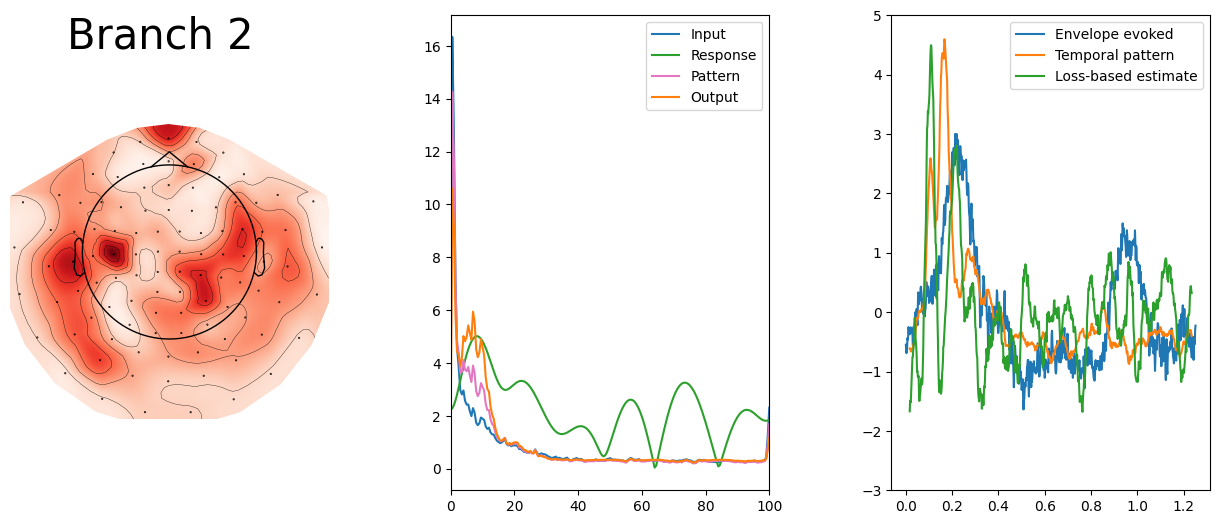

In [23]:
fig = model.plot_branch(2, epochs.info, ['input', 'response', 'pattern', 'output'])

AttributeError: 'SimpleNetA' object has no attribute 'envconv'

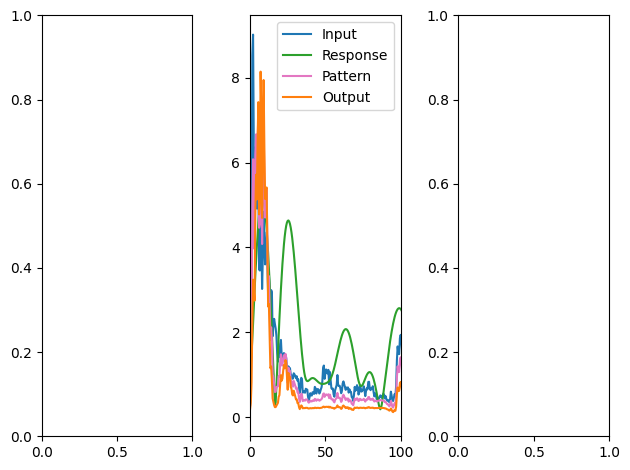

In [16]:
fig= model.plot_branch(2, epochs.info, ['input', 'response', 'pattern', 'output'])

## Compute patterns + estimate compression weights

In [79]:
model.compute_patterns()

Computing patterns: No path specified, using validation dataset (Default)


NameError: name 'self_weights' is not defined

In [78]:
model.temp_patterns.shape

(134, 1, 33, 16)

In [80]:
model.envelopes.shape

(134, 1, 331, 16)

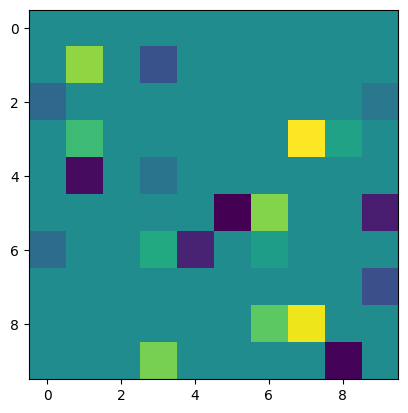

In [22]:
plt.imshow(model.pool_list[0].timesel.weights[0].numpy())

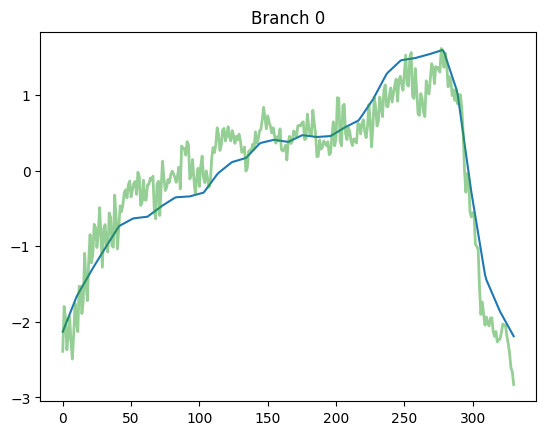

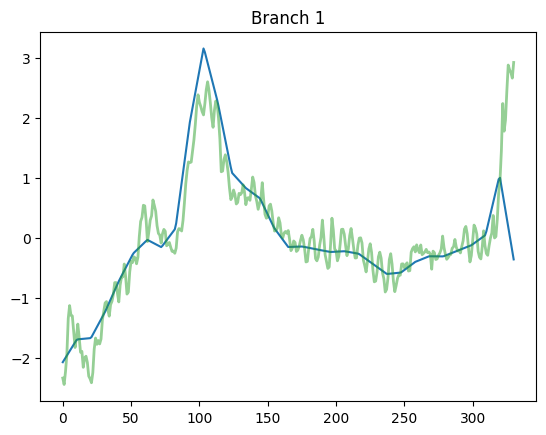

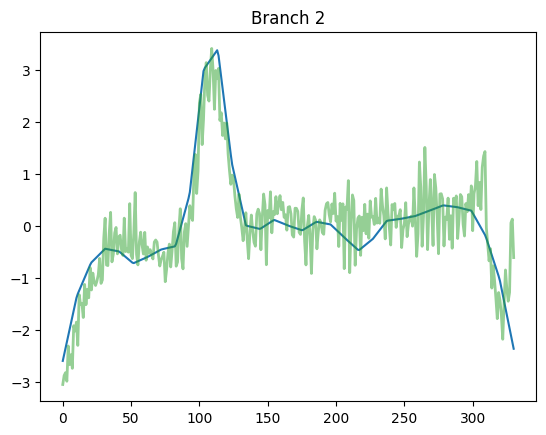

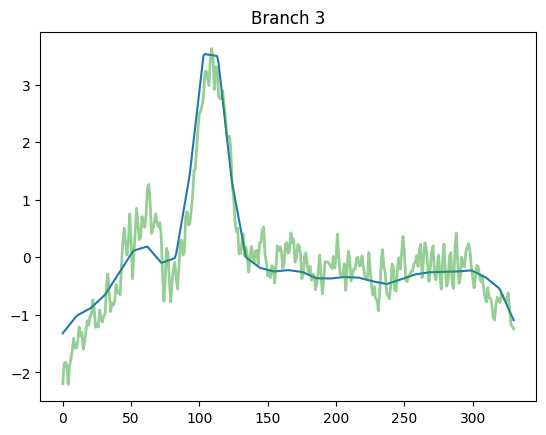

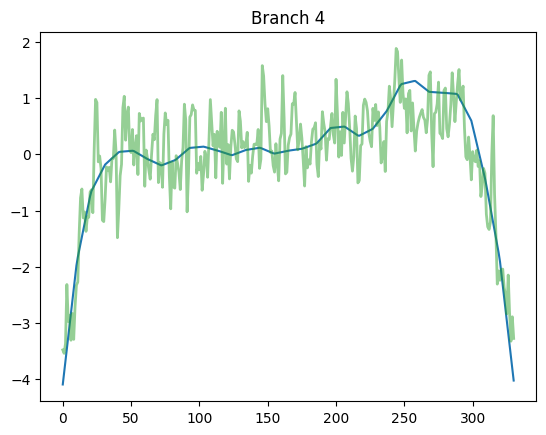

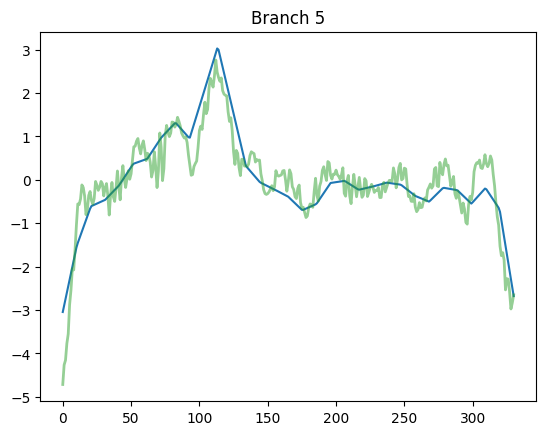

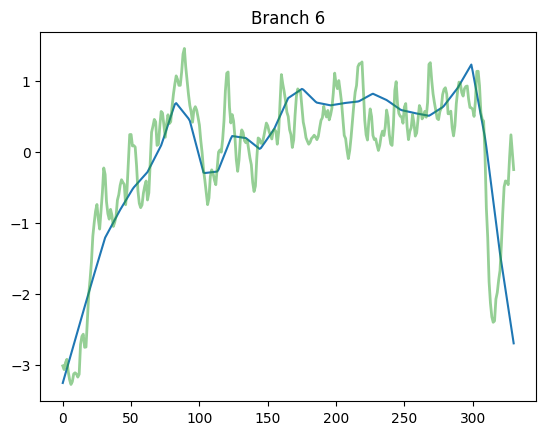

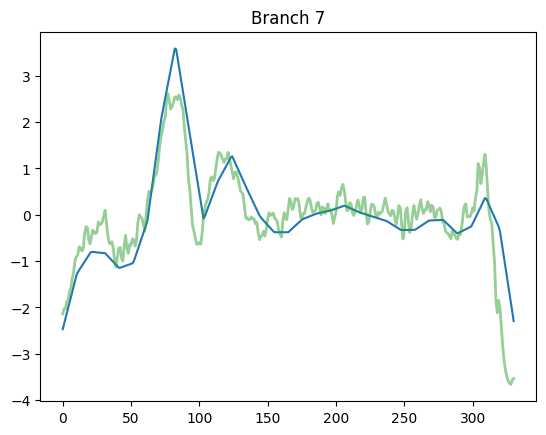

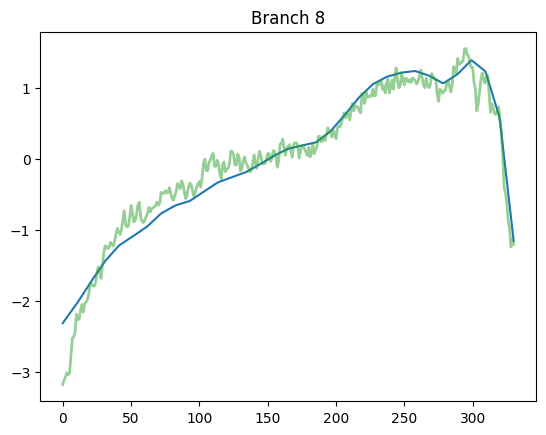

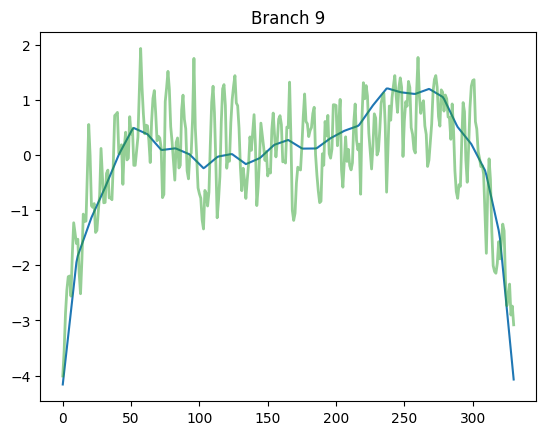

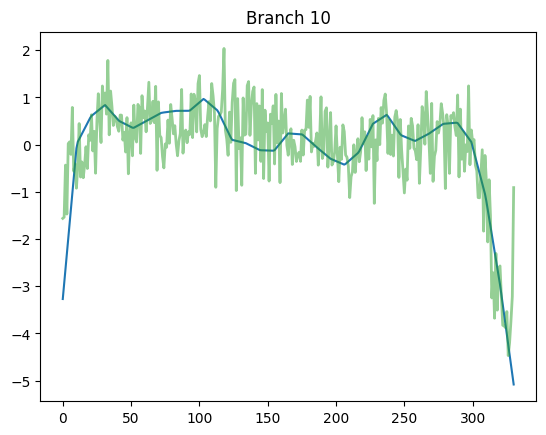

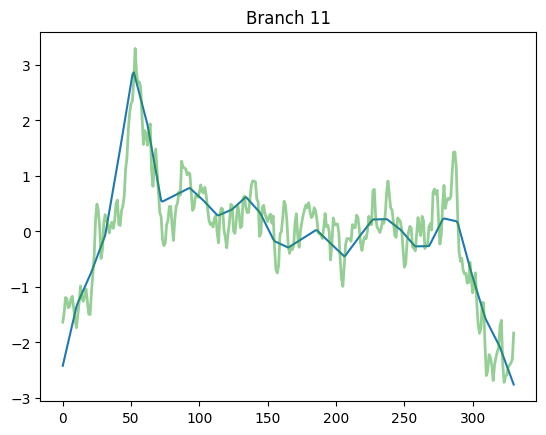

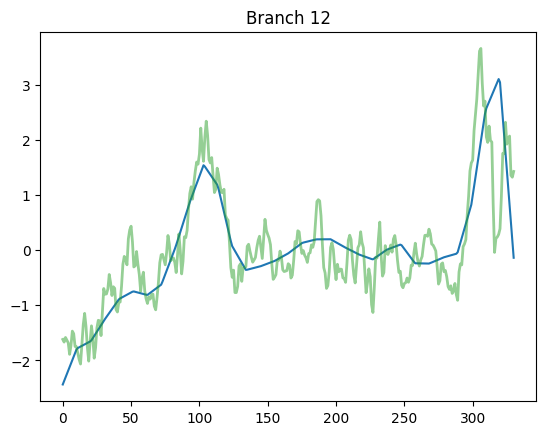

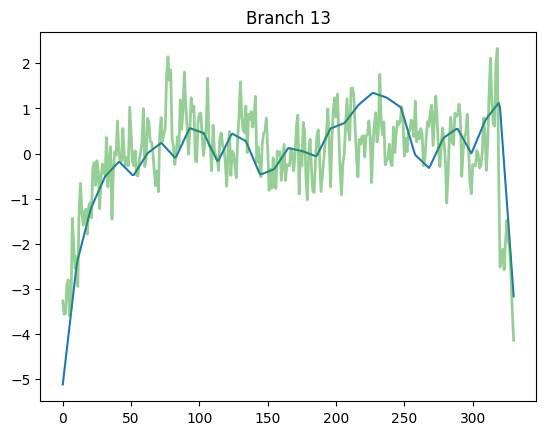

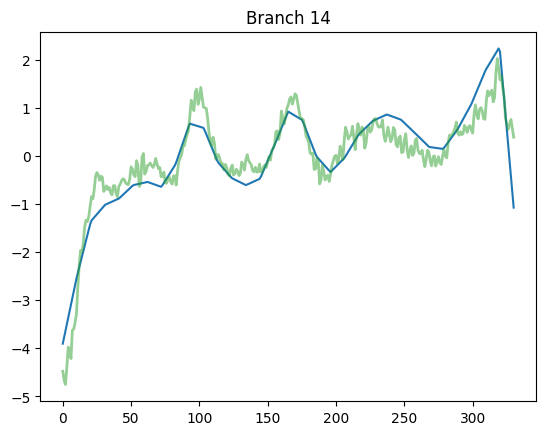

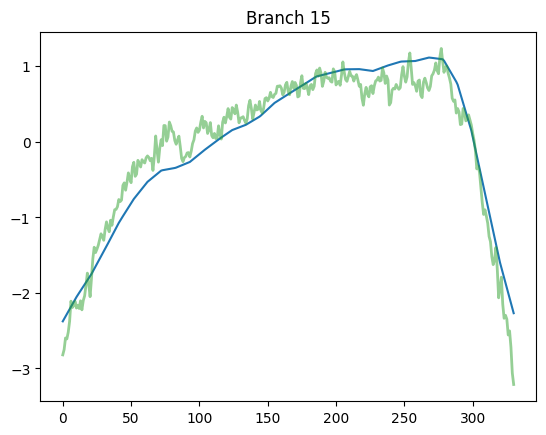

In [24]:
# model.temp_patterns.shape: (134, 1, 33, 16)
# model.envelopes.shape: (134, 1, 331, 16)
from deepmeg.params import moving_average
epoch_n = 0
import scipy as sp
for i in range(model.specs['n_latent']):
    temp = model.temp_patterns[:, 0, :, i]
    env = model.envelopes[:, 0, :, i]
    temp = interpolate_sequence(temp.mean(0), env.shape[1])
    plt.plot(sp.stats.zscore(temp))
    plt.plot(sp.stats.zscore(env.mean(0)), color='tab:green',  alpha=0.5, linewidth=2.)
    # temp = interpolate_sequence(temp[epoch_n], env.shape[1])
    # plt.plot(sp.stats.zscore(temp))
    # plt.plot(sp.stats.zscore(env[epoch_n]), color='tab:green',  alpha=0.5, linewidth=2.)
    # plt.plot(moving_average(sp.stats.zscore(env[epoch_n])))
    plt.title(f'Branch {i}')
    plt.show()

In [106]:
w = model.pool_list[1].weights[0].numpy()

In [59]:
w

array([[ 0.02896886, -0.06170947, -0.0962153 , ..., -0.05988093,
         0.02152992,  0.00450719],
       [-0.08255999, -0.06264235,  0.01997871, ...,  0.10415293,
        -0.01312754,  0.0683956 ],
       [ 0.04631373,  0.10061904,  0.09423082, ..., -0.05859449,
         0.02117532,  0.02146105],
       ...,
       [ 0.10290742,  0.09627703,  0.00451006, ...,  0.03602655,
        -0.06179096,  0.11110397],
       [-0.01609186, -0.02728628, -0.05451329, ..., -0.10984932,
        -0.12193803, -0.07026548],
       [ 0.09642722,  0.06570335, -0.09724208, ...,  0.1016499 ,
        -0.04642114, -0.06553352]], dtype=float32)

## Visualize compression weights for a branch. Its shape: n_times x n_downsampled_times

## Visualize 1st branch (branch importance estimated according to its loss)

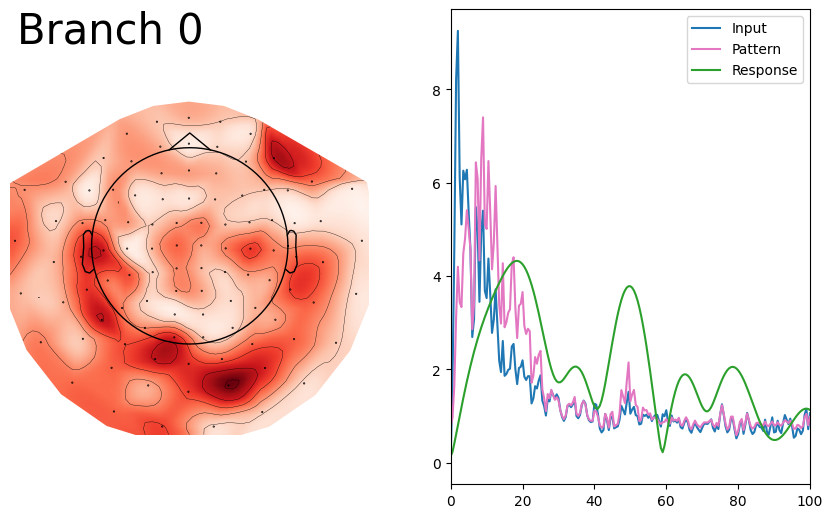

In [36]:
fig = model.plot_branch(0, epochs.info, params=['input', 'pattern', 'response'])